# Forecast analysis

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from enum import Enum
from ngboost.scores import LogScore
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import Exponential, Normal, LogNormal
from ngboost.scores import LogScore, CRPScore
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import ephem
from datetime import datetime
import pickle
from pathlib import Path
import pypsa

paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv",
         "era5_regions": "resources/europe-2013-era5-regions.nc",
         "res_pypsa_q40": "resources/pypsa/results/networks/elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc",
         "res_pypsa_q60": "resources/pypsa/results/networks/elec_s_37_q60_ec_lv1.0_Co2L0.0-1H.nc",
         "res_pypsa_qo": "resources/pypsa/results/networks/elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc"}

In [2]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
capfacts = pd.read_csv(paths["capfacs"])
capfacts_pred_q40 = pd.read_csv("results/capfacts_pred_q40.csv", index_col=0)
capfacts_pred_q40_clipped = pd.read_csv("results/capfacts_pred_q40_clipped.csv", index_col=0)
capfacts_pred_q60 = pd.read_csv("results/capfacts_pred_q60.csv", index_col=0)
capfacts_pred_q60_clipped = pd.read_csv("results/capfacts_pred_q60_clipped.csv", index_col=0)

In [3]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

class EnergyType(Enum):
    """
    Represents the different type of renewable energy sources in pypsa-eur
    """
    OFFWIND_AC = "offwind-ac"
    OFFWIND_DC = "offwind-dc"
    OFFWIND = "offwind"
    ONWIND = "onwind"
    WIND = "wind"
    SOLAR = "solar"
    ROR = "ror"
    NOT_DEFINED = "not_defined"

class Feature(Enum):
    """
    Represents the features, that can be extracted from the era-5 weather data set
    """
    HEIGHT = "height"
    WND100M = "wnd100m"
    ROUGHNESS = "roughness"
    INFLUX_TOA = "influx_toa"
    INFLUX_DIRECT = "influx_direct"
    INFLUX_DIFFUSE = "influx_diffuse"
    ALBEDO = "albedo"
    TEMPERATURE = "temperature"
    SOIL_TEMPERATURE = "soil_temperature"
    RUNOFF = "runoff"

"""
Determines which features are selected to calculate the capacity factor of a certain energy type.
"""
feature_set = {
    EnergyType.OFFWIND_AC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.OFFWIND_DC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.ONWIND: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.SOLAR: [Feature.INFLUX_TOA, Feature.INFLUX_DIRECT, Feature.INFLUX_DIFFUSE, Feature.TEMPERATURE],
    EnergyType.ROR: []
}

def filter_by_energy_type(df: pd.DataFrame, energy_type: EnergyType) -> pd.DataFrame:
    re=".*"
    match energy_type:
        case EnergyType.SOLAR:
            re = ".*solar"
        case EnergyType.OFFWIND_AC:
            re = ".*offwind-ac"
        case EnergyType.OFFWIND_DC:
            re = ".*offwind-dc"
        case EnergyType.ONWIND:
            re = ".*onwind"
        case EnergyType.WIND:
            re = ".*(offwind-ac|offwind-dc|onwind)"
        case EnergyType.OFFWIND:
            re = ".*(offwind-ac|offwind-dc)"
    return df.filter(regex=re)


def find_countries_in_capfacts(country_name="") -> list:
    """
    Returns the full region names and energy types of the given name abbreviation that can be found in the .csv file with capacity factors.
    :param country_name: Two character abbreviation of the searched country
    :return: list of all regions and energy types to the given country name
    """
    countries = []
    for column in capfacts:
        if column.find(country_name) >= 0:
            countries.append(column)
    return countries


def get_energy_type(name: str) -> EnergyType:
    """
    Returns the energy type for a given string
    :param name: energy type as string
    :return: energy type for the given string
    """
    match name:
        case "offwind-ac":
            return EnergyType.OFFWIND_AC
        case "offwind-dc":
            return EnergyType.OFFWIND_DC
        case "onwind":
            return EnergyType.ONWIND
        case "solar":
            return EnergyType.SOLAR
        case "ror":
            return EnergyType.ROR
        case _:
            return EnergyType.NOT_DEFINED

def get_ds_region_name(region_name: str, energy_type: EnergyType) -> str:
    """
    Returns the name or string that addresses the given region and energy type which can be used to address the data in the feature data set
    :param region_name: name of the region
    :param energy_type: the uses energy type in that region
    :return: string that can be used to fetch data from the feature data set
    """
    ds_region_name = region_name + " 0"
    if energy_type == EnergyType.ONWIND or energy_type == EnergyType.SOLAR or energy_type == EnergyType.ROR:
        ds_region_name += " on"
    elif energy_type == EnergyType.OFFWIND_AC or energy_type == EnergyType.OFFWIND_DC:
        ds_region_name += " off"
    else:
        ds_region_name += ""
    return ds_region_name

def parse_capfac_col(column_name: str) -> (str, EnergyType):
    """
    Returns a tuple of the region name and energy type for a given column name of the capfacts .csv file
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of a region name and energy type, None if no region is found
    """
    col_args = column_name.split(" ")
    if len(col_args) == 3:
        region_name = col_args[0]
        energy_type = get_energy_type(col_args[2])
        return region_name, energy_type
    return None, None

def create_training_data_for_col(column_name: str) -> (np.ndarray, dict):
    """
    Creates and returns the the training data set with the relevant data for a given column name from the capfacts .csv file.
    The training data set is a tuple of a numpy array of capacity factors (target values) and a dictionary of the era5 data (feature data),
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of capacity factor (Y) and trainings data (X)
            X                       : DataFrame object or List or numpy array of predictors (n x p) in Numeric format
            Y                       : DataFrame object or List or numpy array of outcomes (n) in Numeric format.
    """
    region_name, energy_type = parse_capfac_col(column_name)
    # print(region_name)
    # print(energy_type)
    ds_region_name = get_ds_region_name(region_name, energy_type)
    # print(ds_region_name)
    features = feature_set.get(energy_type)
    # print(features)

    Y_capfac = capfacts[column_name].values
    X = {}
    for feature in features:
        X[feature] = ds.sel(region=ds_region_name)[feature.value].values

    return Y_capfac, X


def shape_multi_feature_data(training_data: dict):
    """
    Reshapes the trainingsdata in an array of shape (n_samples, n_features)
    (8760, 2) ---> [[x_f1_1, x_f2_1], [x_f1_2, x_f2_2], ... , [x_f1_8760, x_f2_8760]]
    :param training_data as a dictinary of multiple 1-d arrays:
    :return: trainingsdata in array of shape (n_samples,  n_features)
    """
    # tup = tuple(list(training_data.values()))
    # multi_feature_train_data = np.column_stack(tup)
    arrays = list(training_data.values())
    return np.stack(arrays, axis=-1)

In [4]:
capfacts

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


## Capacity Factor Analysis

In [5]:
regions = capfacts_pred_q40.columns.values[1:]

idx_names = ["real_mean", "q40_mean", "q40_clipped_mean","q60_mean", "q60_clipped_mean", "20% confidence"]
idx = dict(zip(idx_names, idx_names))
capfacts_analysis = pd.DataFrame(index = idx)

new_columns = {}

for region in regions:
    values = {}
    values[idx["real_mean"]] = capfacts[region].mean()
    values[idx["q40_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q60_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q40_clipped_mean"]] = capfacts_pred_q40_clipped[region].mean()
    values[idx["q60_clipped_mean"]] = capfacts_pred_q60_clipped[region].mean()
    values[idx["20% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q40[region], capfacts_pred_q60[region])

    new_columns[region] = pd.Series(values)

new_columns = pd.DataFrame(new_columns, index=capfacts_analysis.index)
capfacts_analysis = pd.concat([capfacts_analysis, new_columns], axis = 1)
capfacts_analysis

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
real_mean,0.144222,0.059075,0.131122,0.133949,0.102517,0.047873,0.113904,0.461893,0.520243,0.290474,...,0.116954,0.411495,0.497266,0.221257,0.095503,0.127760,0.057465,0.106495,0.142276,0.104567
q40_mean,0.135868,0.053726,0.120950,0.125559,0.094300,0.044585,0.105111,0.451567,0.509520,0.282439,...,0.108525,0.394833,0.468410,0.211098,0.086383,0.126285,0.054406,0.097238,0.131129,0.096594
q40_clipped_mean,0.135872,0.053739,0.121467,0.125564,0.094621,0.044585,0.105734,0.451653,0.509522,0.282440,...,0.108908,0.394833,0.468411,0.211098,0.086841,0.126340,0.054428,0.097675,0.131175,0.096954
q60_mean,0.135868,0.053726,0.120950,0.125559,0.094300,0.044585,0.105111,0.451567,0.509520,0.282439,...,0.108525,0.394833,0.468410,0.211098,0.086383,0.126285,0.054406,0.097238,0.131129,0.096594
q60_clipped_mean,0.154631,0.063998,0.140525,0.141714,0.110434,0.051078,0.122531,0.472095,0.532476,0.299149,...,0.125283,0.428621,0.525020,0.230770,0.105387,0.129396,0.060501,0.116023,0.151622,0.113527
20% confidence,0.184361,0.167580,0.164840,0.193836,0.221233,0.174315,0.178653,0.366324,0.357306,0.200228,...,0.207534,0.163242,0.164041,0.182763,0.147831,0.524658,0.199315,0.168950,0.186758,0.098288


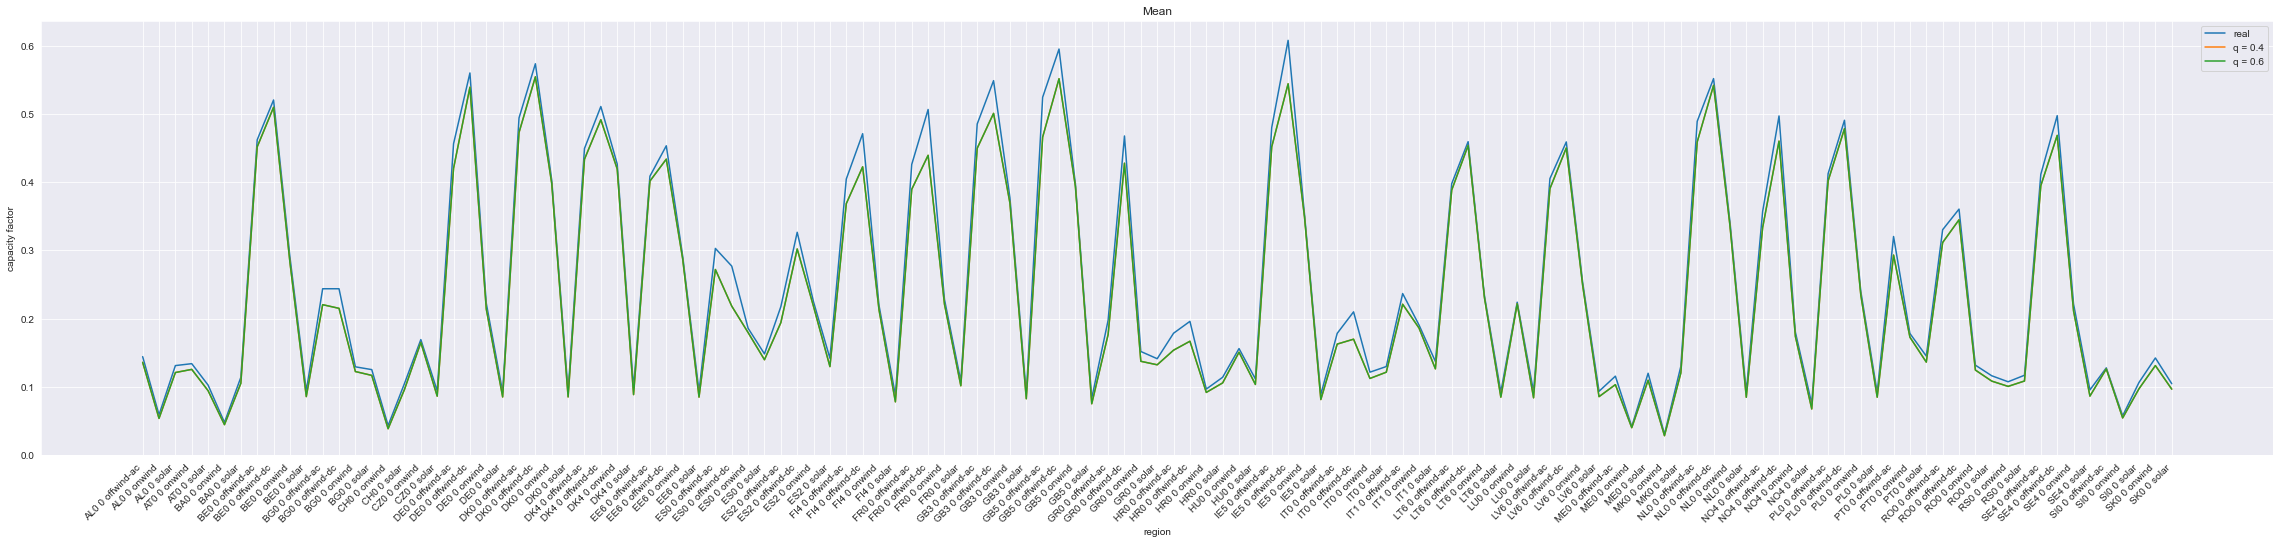

In [6]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis.loc["real_mean"], label="real")
plt.plot(capfacts_analysis.loc["q40_mean"], label="q = 0.4")
plt.plot(capfacts_analysis.loc["q60_mean"], label="q = 0.6")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factor")
plt.title("Mean")
plt.legend()
plt.savefig("results/capfacts_mean.png")

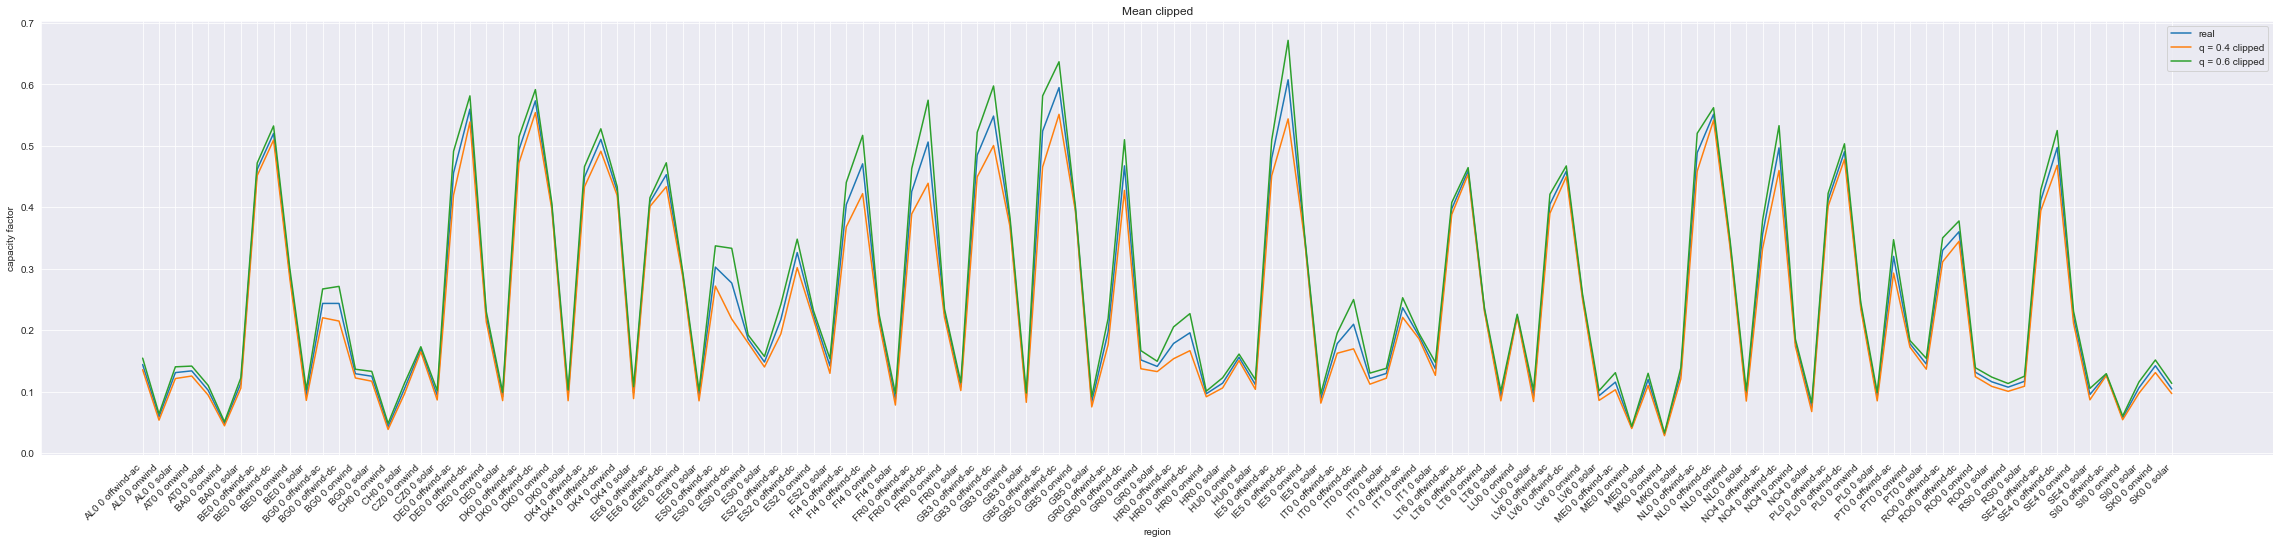

In [7]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis.loc["real_mean"], label="real")
plt.plot(capfacts_analysis.loc["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis.loc["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factor")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean.png")

In [8]:
capfacts_analysis_wind = filter_by_energy_type(capfacts_analysis, EnergyType.WIND)
capfacts_analysis_onwind = filter_by_energy_type(capfacts_analysis, EnergyType.ONWIND)
capfacts_analysis_offwind = filter_by_energy_type(capfacts_analysis, EnergyType.OFFWIND)
capfacts_analysis_solar = filter_by_energy_type(capfacts_analysis, EnergyType.SOLAR)

### Clipped capacity factors for Wind (mean)

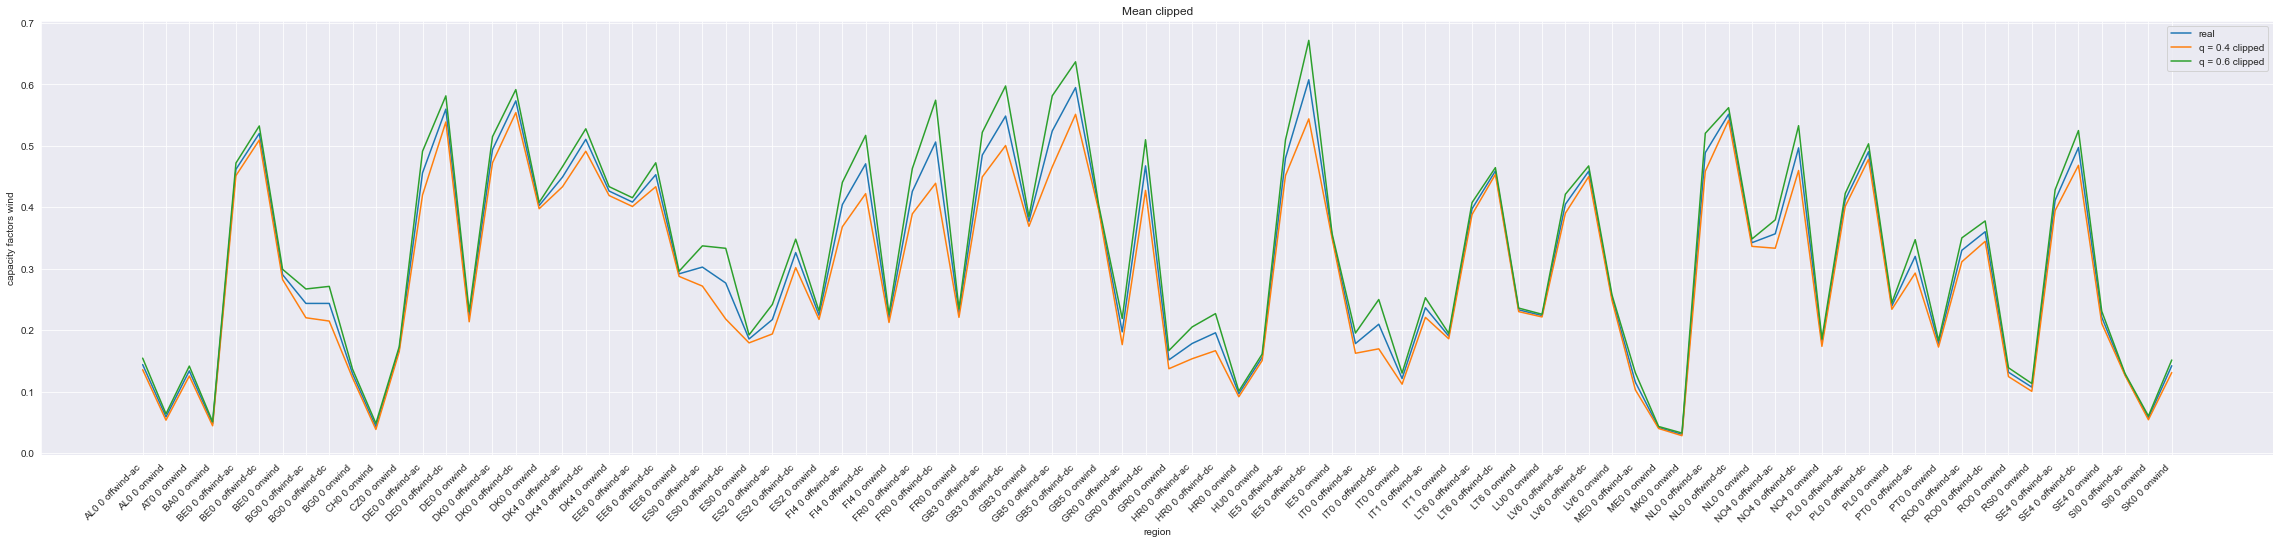

In [9]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_wind.loc["real_mean"], label="real")
plt.plot(capfacts_analysis_wind.loc["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis_wind.loc["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factors wind")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean_wind.png")

### Clipped capacity factors for offwind and onwind (mean)

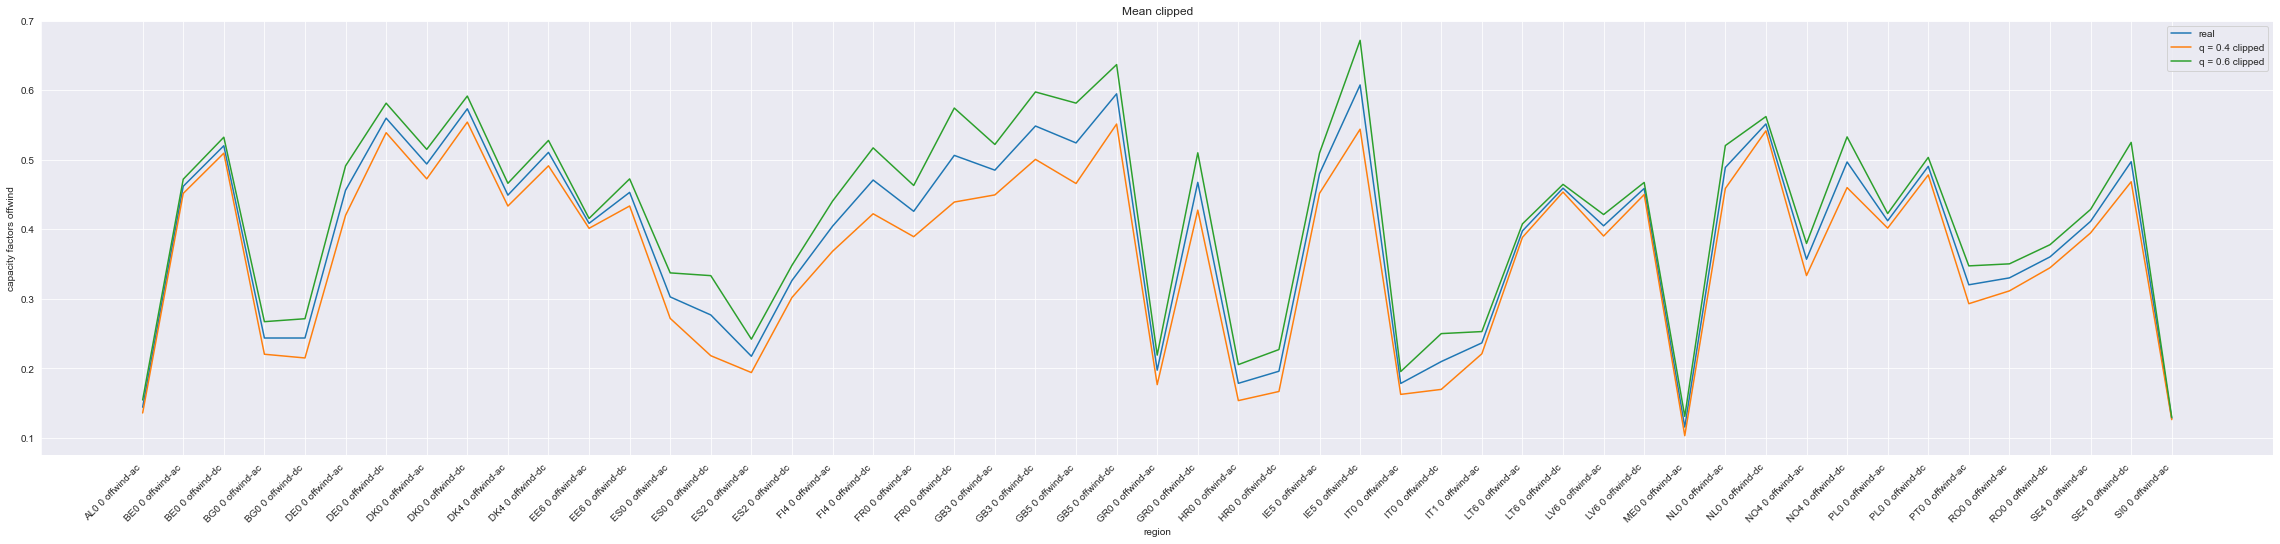

In [10]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_offwind.loc["real_mean"], label="real")
plt.plot(capfacts_analysis_offwind.loc["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis_offwind.loc["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factors offwind")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean_offwind.png")

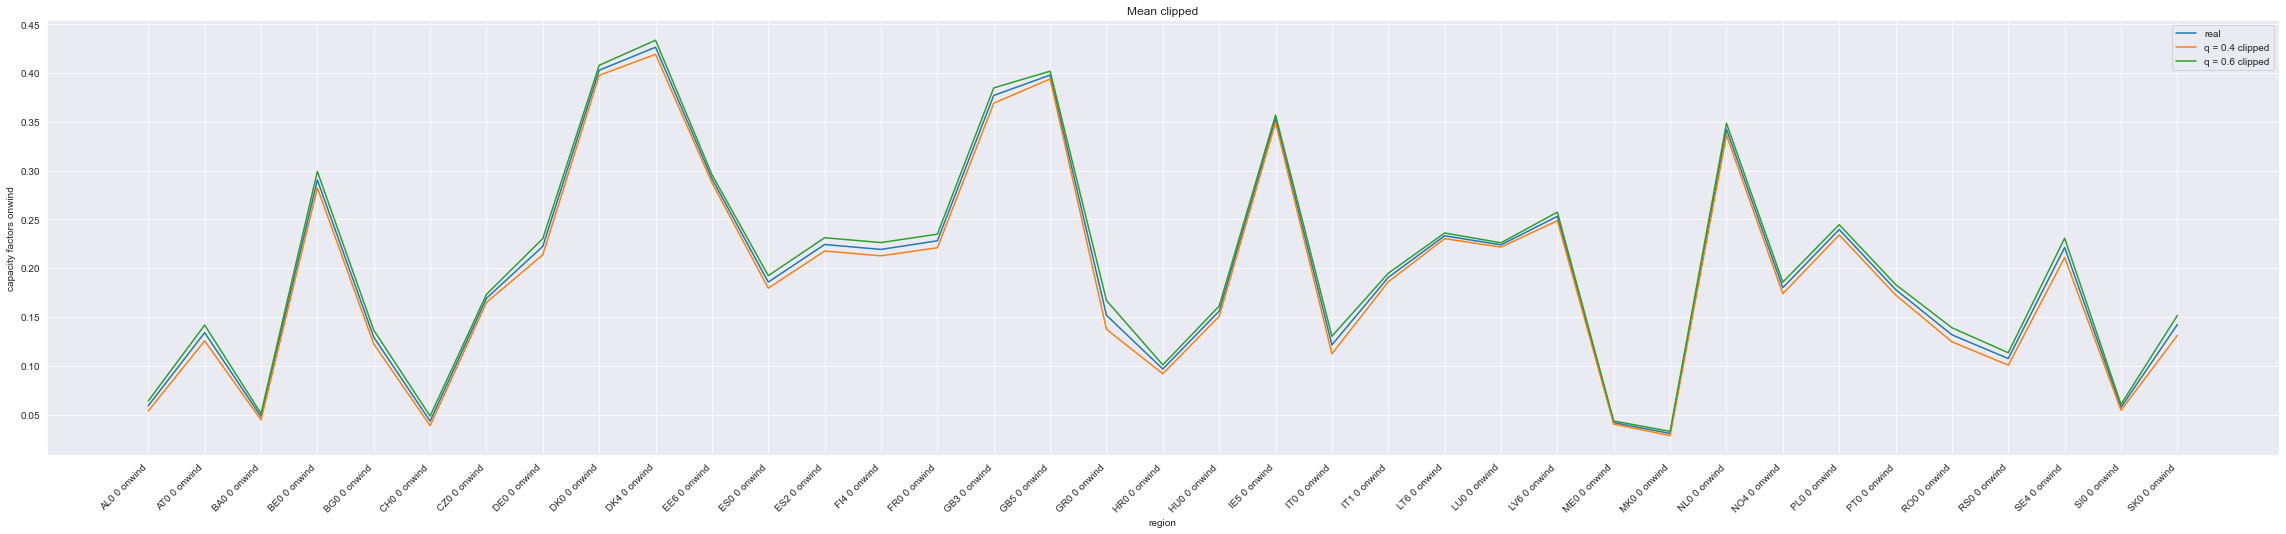

In [11]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_onwind.loc["real_mean"], label="real")
plt.plot(capfacts_analysis_onwind.loc["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis_onwind.loc["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factors onwind")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean_onwind.png")

### Clipped capacity factors for solar (mean)

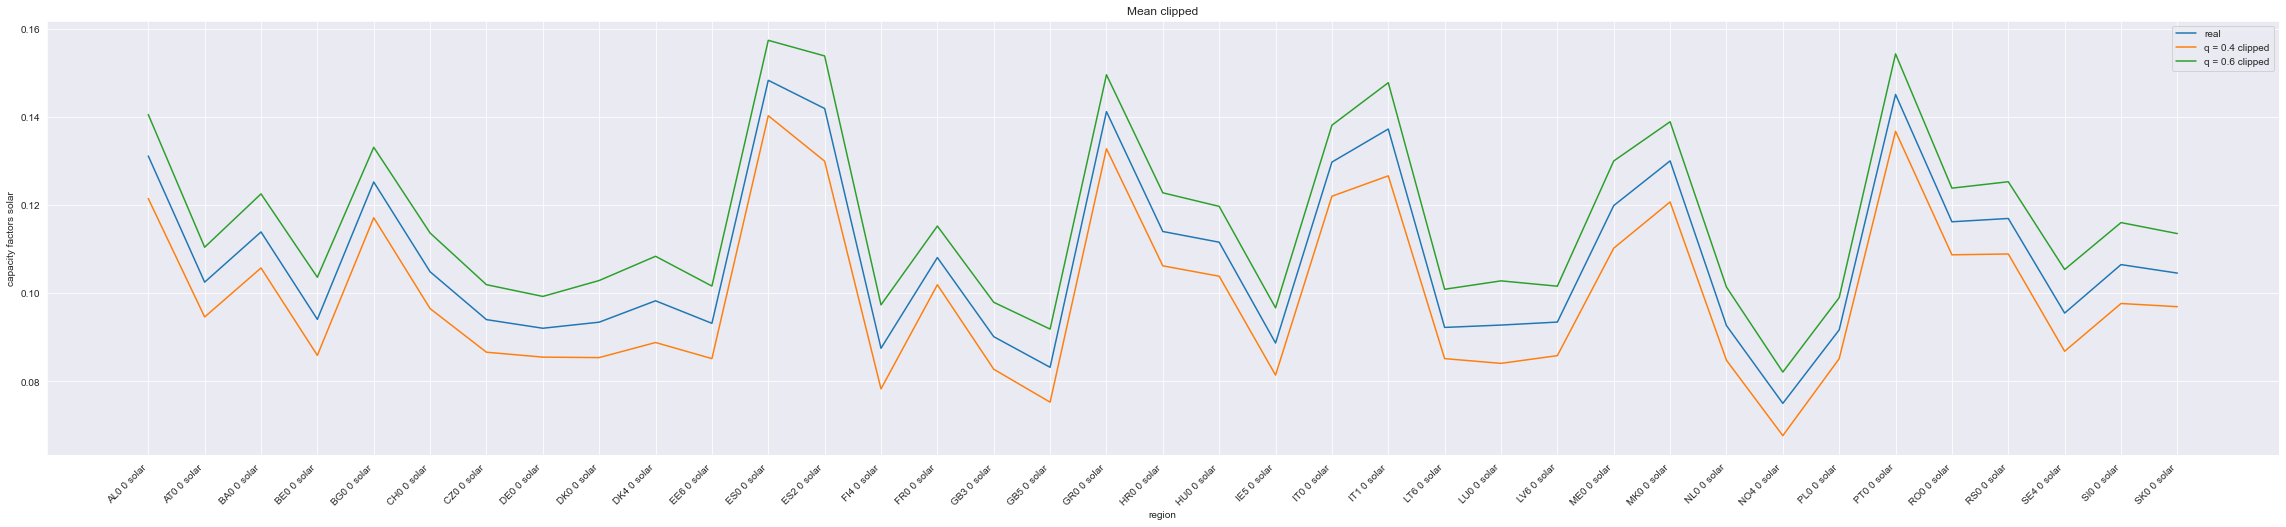

In [12]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_solar.loc["real_mean"], label="real")
plt.plot(capfacts_analysis_solar.loc["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis_solar.loc["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("capacity factors solar")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean_solar.png")

### 20% confidence interfall

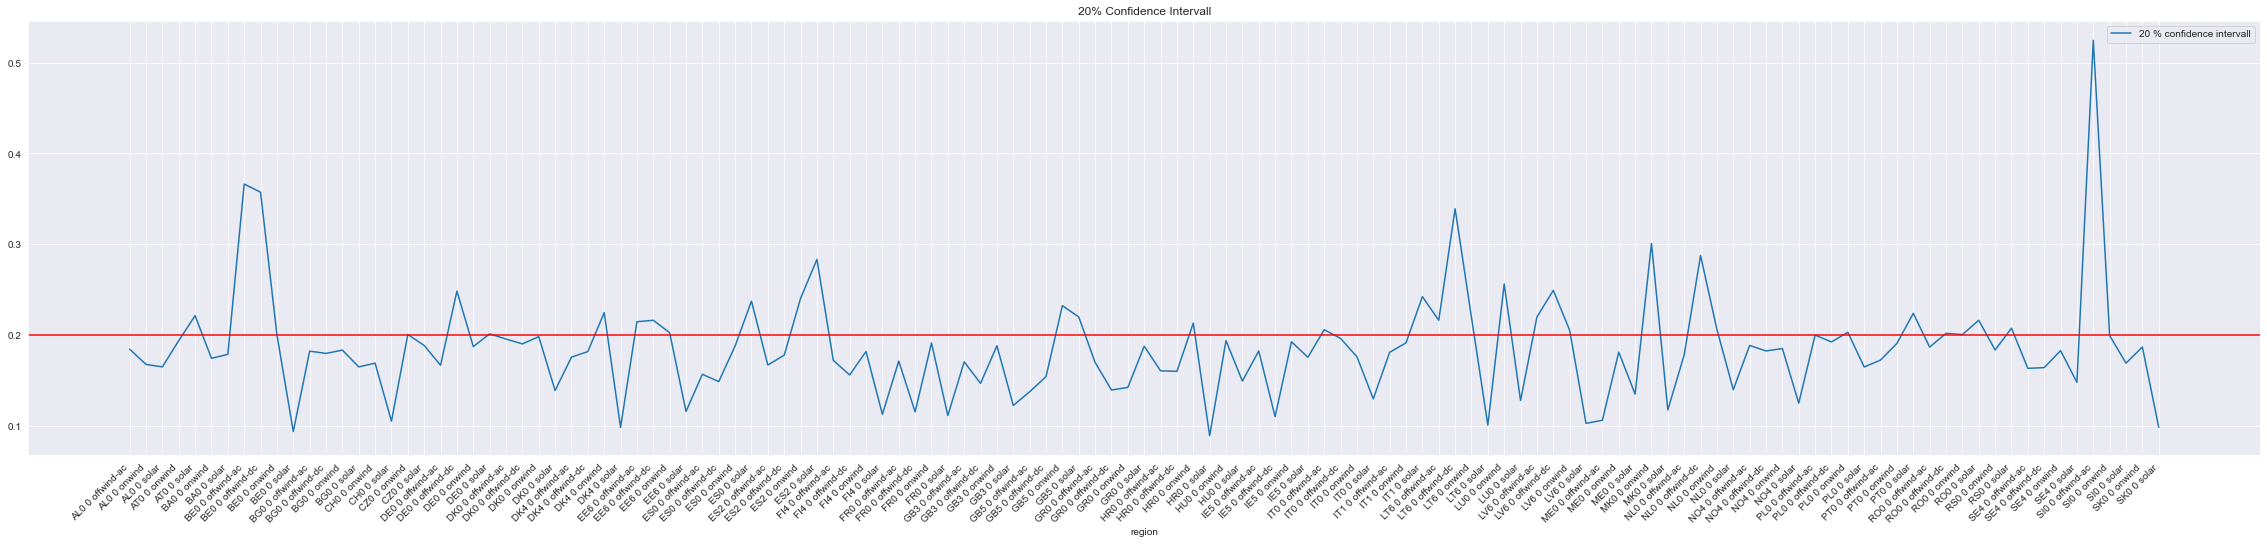

In [13]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis.loc["20% confidence"], label="20 % confidence intervall")
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("")
plt.title("20% Confidence Intervall")
plt.legend()
plt.savefig("results/20p_confidence.png")

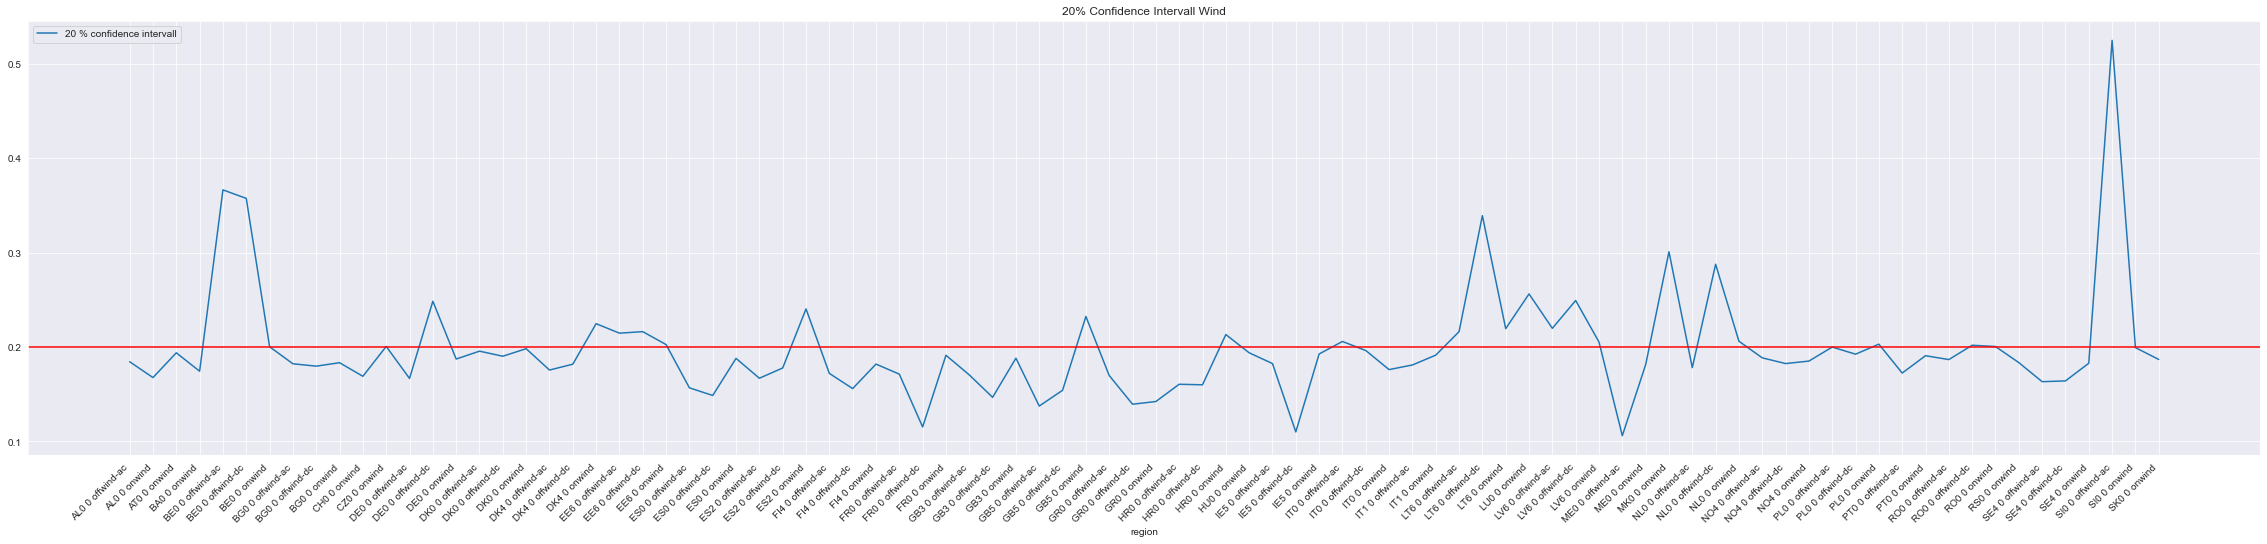

In [14]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_wind.loc["20% confidence"], label="20 % confidence intervall")
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("")
plt.title("20% Confidence Intervall Wind")
plt.legend()
plt.savefig("results/20p_confidence_wind.png")

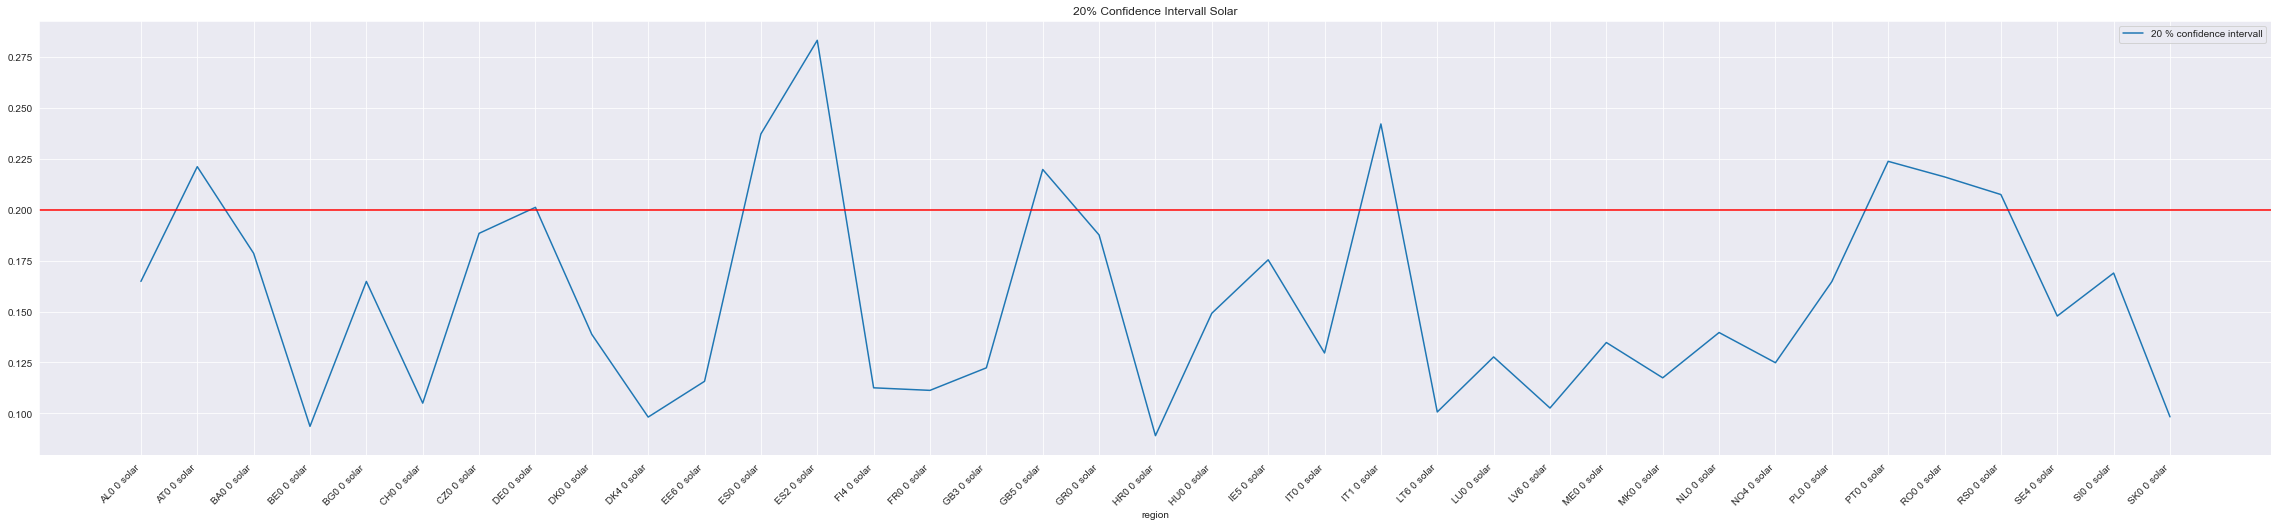

In [15]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis_solar.loc["20% confidence"], label="20 % confidence intervall")
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel("region")
plt.xticks(rotation=45, ha='right')
plt.ylabel("")
plt.title("20% Confidence Intervall Solar")
plt.legend()
plt.savefig("results/20p_confidence_solar.png")

## PyPSA

### Snakemake Configuration

**elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc**
- *ec*: extra components https://pypsa-eur.readthedocs.io/en/latest/simplification/add_extra_components.html
- *lv1.0*: line volume limit 1.0 (no expension)
- *-1H*: Resample the time-resolution by averaging over every 1 snapshots
- *Co2L0.0*: Add an overall absolute carbon-dioxide emissions limit configured in electricity: co2limit. If a float is appended an overall emission limit relative to the emission level given in electricity: co2base is added (e.g. Co2L0.05 limits emissisions to 5% of what is given in electricity: co2base)


### Energy flow in the model
Energy enters the model in generators, storage units or stores with higher energy before than after the simulation, and any components with efficiency greater than 1 (e.g. heat pumps).
Energy leaves the model in loads, storage units or stores with higher energy after than before the simulation, and in lines, links or storage units with efficiency less than 1.

In [16]:
no = pypsa.Network(paths["res_pypsa_qo"])
n4 = pypsa.Network(paths["res_pypsa_q40"])
n6 = pypsa.Network(paths["res_pypsa_q60"])

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the relea

### Network structure

#### Lines Type
All networks are having the same lines (and same types)
Lines include distribution and transmission lines, overhead lines and cables.

In [133]:
no.iplot()

{'data': [{'x': Bus
   AL1 0            19.897914
   AT1 0            13.604274
   BA1 0            18.122704
   BE1 0             4.617461
   BG1 0            24.673671
                      ...    
   RO1 0 battery    25.091770
   RS1 0 battery    20.662692
   SE2 0 battery    16.277634
   SI1 0 battery    14.693952
   SK1 0 battery    19.027888
   Name: x, Length: 111, dtype: float64,
   'y': Bus
   AL1 0            41.587568
   AT1 0            47.549498
   BA1 0            43.811367
   BE1 0            50.818887
   BG1 0            42.765271
                      ...    
   RO1 0 battery    45.551309
   RS1 0 battery    44.113710
   SE2 0 battery    61.357761
   SI1 0 battery    46.071068
   SK1 0 battery    48.653333
   Name: y, Length: 111, dtype: float64,
   'text': Index(['Bus AL1 0', 'Bus AT1 0', 'Bus BA1 0', 'Bus BE1 0', 'Bus BG1 0',
          'Bus CH1 0', 'Bus CZ1 0', 'Bus DE1 0', 'Bus DK1 0', 'Bus DK2 0',
          ...
          'Bus MK1 0 battery', 'Bus NL1 0 battery', 'B

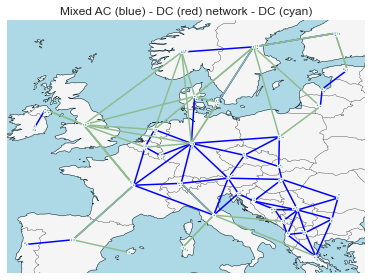

In [17]:
lines_current_type = no.lines.bus0.map(no.buses.carrier)

no.plot(
    line_colors=lines_current_type.map(lambda ct: "r" if ct == "DC" else "b"),
    title="Mixed AC (blue) - DC (red) network - DC (cyan)",
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()

In [18]:
lines_current_type_no = no.lines.bus0.map(no.buses.carrier)
lines_current_type_n4 = n4.lines.bus0.map(n4.buses.carrier)
lines_current_type_n6 = n6.lines.bus0.map(n6.buses.carrier)
pd.DataFrame(data=[lines_current_type_no, lines_current_type_n4, lines_current_type_n6])

Line,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
bus0,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC,...,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC
bus0,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC,...,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC
bus0,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC,...,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC


- Different *capital_costs* (n4 < no < n6). How is ist calculated?
- s_nom_extendable is false (so amount of transported electricity can't change?

In [19]:
no.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18062.457827,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7100.654512,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6694.467720,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13707.363978,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19771.693455,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13412.361706,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22993.731701,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18994.726745,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22146.337436,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [20]:
n4.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18064.741291,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7101.356427,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6692.250680,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13703.940745,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19764.328731,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13408.144933,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22991.438748,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18997.480387,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22142.508192,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [21]:
n6.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18060.194747,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7099.679048,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6693.995207,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13704.822600,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19770.515487,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13413.204189,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22998.575624,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18994.485282,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22148.957220,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


#### Temporal resolution
Hourly resolution for all of 2013

In [22]:
n4.snapshots

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Generators
- Same (amount) of generators
- solar, onwind, offwind-dc and offwind-ac are extentable, meaning that capacities can be extended in the optimization. Conventional energy generators are not extendable
- different *marginal_cost* and *p_nom_opt* for renewables
- existent capacities given by network.generators.p_nom in lopf optimization
- The optimal capacities are given by *p_nom_opt* for generators, links and storages and *s_nom_opt* for lines
- The power (p,q) of generators or storage units is positive if the asset is injecting power into the bus, negative if withdrawing power from bus.

In [23]:
no.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.025517,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.235920,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025056,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.010623,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.019365,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.498231,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911082,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.024622,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [24]:
n4.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.025379,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.236029,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025530,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.009127,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.020949,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.497892,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911105,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.025343,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [25]:
n6.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.024147,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.237220,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025846,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.010771,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.020571,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.497041,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911954,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.025768,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


### System Costs
Real System costs
Compare relative change in costs

#### Total system costs

In [26]:
print("System cots of no:", no.objective + no.objective_constant)
print("System cots of n4:", n4.objective + n4.objective_constant)
print("System cots of n6:", n6.objective + n6.objective_constant)

System cots of no: 166332544386.2526
System cots of n4: 170599711237.95563
System cots of n6: 151479372612.50378


#### Marginal costs for all buses over a year
Todo: Compare marginal costs of generators, h2 and battery
Locational marginal price from LOPF from power balance constraint in currency/MWh

In [27]:
# no.buses_t.marginal_price.plot(title="Price Duration Curve", figsize=(9, 5)) # group by type
no.buses_t.marginal_price

Bus,AL1 0,AT1 0,BA1 0,BE1 0,BG1 0,CH1 0,CZ1 0,DE1 0,DK1 0,DK2 0,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,444.117890,-0.003954,466.278111,4.146745,422.637146,22.660485,5.259545,0.025215,0.024977,0.024648,...,389.377625,0.676648,30.344891,0.591505,66.493455,373.276363,393.108486,23.200872,529.961271,18.136729
2013-01-01 01:00:00,376.696133,-0.003907,395.602656,4.146777,358.368787,15.231551,5.279247,0.025220,0.025008,0.024647,...,359.039254,0.696760,30.350029,0.581538,66.493441,342.657472,362.111399,22.279175,488.227869,17.830242
2013-01-01 02:00:00,275.913113,-0.003989,290.019812,4.146772,262.238589,4.161248,5.773082,0.025222,0.025057,0.024646,...,281.359454,0.734652,30.360379,0.578282,66.493418,269.542198,285.105843,21.933190,385.104365,17.605847
2013-01-01 03:00:00,243.581711,-0.003916,256.127414,4.152193,231.420510,0.599812,5.774457,0.025223,0.025113,0.024646,...,253.791795,0.807539,30.372055,0.579146,66.493385,242.275504,256.585734,21.937079,347.625871,17.430670
2013-01-01 04:00:00,241.440363,-0.003947,253.882766,4.991514,229.379348,0.599887,5.774809,0.025225,0.025160,0.024649,...,244.454120,0.942440,30.383100,0.582528,66.493339,231.916608,245.934705,22.289019,333.824197,17.281784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,444.164260,0.003590,466.345943,4.146763,422.663104,22.677784,14.967801,0.025227,0.025022,0.024717,...,389.394137,0.613797,30.337421,0.664393,66.493396,374.330069,394.278027,29.128152,530.092352,30.863016
2013-12-31 20:00:00,444.163386,0.002970,466.343808,4.146896,422.663349,22.676917,5.776294,0.025223,0.025017,0.024713,...,389.394117,0.626884,30.330225,0.656419,66.493428,374.313852,394.245534,28.784133,530.088749,22.421162
2013-12-31 21:00:00,444.117846,0.003496,466.204680,4.147309,422.708228,22.622266,5.775096,0.025225,0.025013,0.024702,...,389.394092,0.650083,30.330147,0.646024,66.493448,374.248370,394.152723,28.313222,530.060239,20.301027


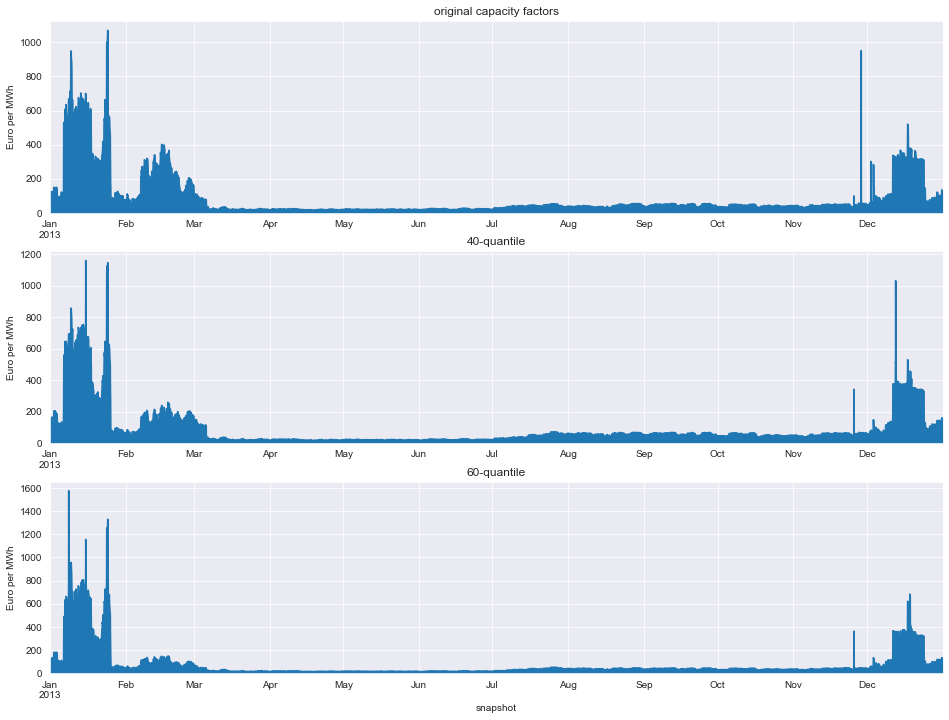

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,12))

no.buses_t.marginal_price.mean(1).plot.area(ylabel="Euro per MWh", xlabel="", ax=ax[0])
n4.buses_t.marginal_price.mean(1).plot.area(ylabel="Euro per MWh", xlabel="", ax=ax[1])
n6.buses_t.marginal_price.mean(1).plot.area(ylabel="Euro per MWh", ax=ax[2])

ax[0].set_title("original capacity factors")
ax[1].set_title("40-quantile")
ax[2].set_title("60-quantile")

plt.show()

### Optimal Capacities
- Capacity = Maximum power output of a generator?
- If a capacity factor is higher, the capacity can be lower to generate the same electric energy
- Lower costs because of lower installed power

In [29]:
def get_result(n):
    RE = ['solar','onwind','offwind-ac','offwind-dc']
    result = n.generators.groupby("carrier").sum().p_nom_opt
    result["offwind"] = result["offwind-ac"]+result["offwind-dc"]

    RE = ['solar','onwind','offwind']
    result = result[RE]
    result.index = ['solar','onshore wind','offshore wind']

    return result

In [30]:
result_o = get_result(no)/1e3
result_4 = get_result(n4)/1e3
result_6 = get_result(n6)/1e3
print("Total optimal capacity [GW] original:", result_o.sum())
print("Total optimal capacity [GW] q=0.4:", result_4.sum())
print("Total optimal capacity [GW] q=0.6:", result_6.sum())

Total optimal capacity [GW] original: 1144.4932080208544
Total optimal capacity [GW] q=0.4: 1201.203558277496
Total optimal capacity [GW] q=0.6: 1022.3588281605419


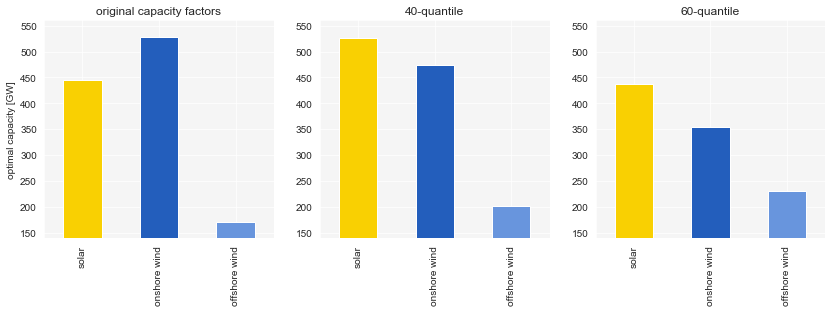

In [31]:
fig, ax = plt.subplots(1,3, figsize=(14,4))

for ax_i in [ax[0], ax[1], ax[2]]:
    ax_i.set_facecolor("whitesmoke")
    ax_i.set_ylim([140, 560])

RE = ['solar','onwind','offwind-ac']
result_o.plot.bar(color=no.carriers.loc[RE].color, ax=ax[0])
result_4.plot.bar(color=no.carriers.loc[RE].color, ax=ax[1])
result_6.plot.bar(color=no.carriers.loc[RE].color, ax=ax[2])

ax[0].set_ylabel("optimal capacity [GW]")

ax[0].set_title("original capacity factors")
ax[1].set_title("40-quantile")
ax[2].set_title("60-quantile")

plt.show()

In [32]:
abs(result_4-result_o)/result_o*100

solar            18.072120
onshore wind     10.241442
offshore wind    17.816610
Name: p_nom_opt, dtype: float64

In [33]:
abs(result_6-result_o)/result_o*100

solar             1.766353
onshore wind     33.066228
offshore wind    35.447407
Name: p_nom_opt, dtype: float64

In [34]:
print(n4.generators_t.p_max_pu.filter(like="solar").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="solar").sum().sum(),
      no.generators_t.p_max_pu.filter(like="solar").sum().sum())

32191.693122129484 37576.53554958304 34984.81538676607


In [35]:

print(n4.generators_t.p_max_pu.filter(like="onwind").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="onwind").sum().sum(),
      no.generators_t.p_max_pu.filter(like="onwind").sum().sum())

61883.875134777045 65723.43816326819 63855.676809046476


In [36]:
print(n4.generators_t.p_max_pu.filter(like="offwind").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="offwind").sum().sum(),
      no.generators_t.p_max_pu.filter(like="offwind").sum().sum())

150151.3300950963 169645.26593223 159806.78293674166


## Components

One-ports share the property that they all connect to a single bus, i.e. generators, loads, storage units, etc.. They share the attributes ```bus```, ```p_set```, ```q_set```, ```p```, ```q```.

In [127]:
no.one_port_components

{'Generator', 'Load', 'ShuntImpedance', 'StorageUnit', 'Store'}

Branches connect two buses. A copy of their attributes can be accessed as a group by the function ```network.branches()```. They share the attributes ```bus0```, ```bus1```.
Passive branches are branches whose power flow is not directly controllable, but is determined passively by their impedances and the nodal power imbalances, i.e. lines and transformers.
Controllable branches are branches whose power flow can be controlled by e.g. the LOPF optimisation, i.e. links.

In [128]:
no.branch_components

{'Line', 'Link', 'Transformer'}

In [129]:
no.branches()

b  b_pu  build_year           bus0  \
component name                                                                  
Line      1                         0.002055   0.0           0          AL1 0   
          2                         0.001079   0.0           0          AL1 0   
          3                         0.000000   0.0           0          AL1 0   
          4                         0.002082   0.0           0          AL1 0   
          5                         0.008996   0.0           0          AT1 0   
...                                      ...   ...         ...            ...   
Link      RO1 0 battery discharger       NaN   NaN           0  RO1 0 battery   
          RS1 0 battery discharger       NaN   NaN           0  RS1 0 battery   
          SE2 0 battery discharger       NaN   NaN           0  SE2 0 battery   
          SI1 0 battery discharger       NaN   NaN           0  SI1 0 battery   
          SK1 0 battery discharger       NaN   NaN           0  SK1 0 battery   

                                     bus1  capital_cost             carrier  \
component name                                                                
Line      1                         GR1 0  18062.457827                  AC   
          2                         ME1 0   7100.654512                  AC   
          3                         MK1 0   6694.467720                  AC   
          4                         RS1 0  13707.363978                  AC   
          5                         CH1 0  19771.693455                  AC   
...                                   ...           ...                 ...   
Link      RO1 0 battery discharger  RO1 0      0.000000  battery discharger   
          RS1 0 battery discharger  RS1 0      0.000000  battery discharger   
          SE2 0 battery discharger  SE2 0      0.000000  battery discharger   
          SI1 0 battery discharger  SI1 0      0.000000  battery discharger   
          SK1 0 battery discharger  SK1 0      0.000000  battery discharger   

                                    charger_ratio  efficiency    g  ...  \
component name                                                      ...   
Line      1                                   NaN         NaN  0.0  ...   
          2                                   NaN         NaN  0.0  ...   
          3                                   NaN         NaN  0.0  ...   
          4                                   NaN         NaN  0.0  ...   
          5                                   NaN         NaN  0.0  ...   
...                                           ...         ...  ...  ...   
Link      RO1 0 battery discharger            NaN         0.9  NaN  ...   
          RS1 0 battery discharger            NaN         0.9  NaN  ...   
          SE2 0 battery discharger            NaN         0.9  NaN  ...   
          SI1 0 battery discharger            NaN         0.9  NaN  ...   
          SK1 0 battery discharger            NaN         0.9  NaN  ...   

                                                           type  \
component name                                                    
Line      1                         Al/St 240/40 4-bundle 380.0   
          2                         Al/St 240/40 4-bundle 380.0   
          3                         Al/St 240/40 4-bundle 380.0   
          4                         Al/St 240/40 4-bundle 380.0   
          5                         Al/St 240/40 4-bundle 380.0   
...                                                         ...   
Link      RO1 0 battery discharger                                
          RS1 0 battery discharger                                
          SE2 0 battery discharger                                
          SI1 0 battery discharger                                
          SK1 0 battery discharger                                

                                   under_construction  underground  \
component name                             

In [131]:
no.passive_branches()

b  b_pu  build_year   bus0   bus1  capital_cost carrier    g  \
Line 1   0.002055   0.0           0  AL1 0  GR1 0  18062.457827      AC  0.0   
     2   0.001079   0.0           0  AL1 0  ME1 0   7100.654512      AC  0.0   
     3   0.000000   0.0           0  AL1 0  MK1 0   6694.467720      AC  0.0   
     4   0.002082   0.0           0  AL1 0  RS1 0  13707.363978      AC  0.0   
     5   0.008996   0.0           0  AT1 0  CH1 0  19771.693455      AC  0.0   
     6   0.004074   0.0           0  AT1 0  CZ1 0  13412.361706      AC  0.0   
     7   0.025316   0.0           0  AT1 0  DE1 0  22993.731701      AC  0.0   
     8   0.005771   0.0           0  AT1 0  HU1 0  18994.726745      AC  0.0   
     9   0.000845   0.0           0  AT1 0  IT1 0  22146.337436      AC  0.0   
     10  0.000334   0.0           0  AT1 0  SI1 0   8771.468402      AC  0.0   
     11  0.003981   0.0           0  BA1 0  HR1 0  10473.643912      AC  0.0   
     12  0.001258   0.0           0  BA1 0  ME1 0   6618.721503      AC  0.0   
     13  0.001491   0.0           0  BA1 0  RS1 0   9816.451670      AC  0.0   
     14  0.014122   0.0           0  BE1 0  FR1 0  21894.592150      AC  0.0   
     15  0.000604   0.0           0  BE1 0  LU1 0   7924.454339      AC  0.0   
     16  0.004001   0.0           0  BE1 0  NL1 0   8794.139273      AC  0.0   
     17  0.002464   0.0           0  BG1 0  GR1 0  21658.552635      AC  0.0   
     18  0.001552   0.0           0  BG1 0  MK1 0  13637.444269      AC  0.0   
     19  0.006754   0.0           0  BG1 0  RO1 0  14843.681118      AC  0.0   
     20  0.001934   0.0           0  BG1 0  RS1 0  16991.822244      AC  0.0   
     21  0.040525   0.0           0  CH1 0  DE1 0  22264.608998      AC  0.0   
     22  0.012569   0.0           0  CH1 0  FR1 0  18381.226494      AC  0.0   
     23  0.012290   0.0           0  CH1 0  IT1 0  21578.289042      AC  0.0   
     24  0.009285   0.0           0  CZ1 0  DE1 0  20403.675242      AC  0.0   
     25  0.004811   0.0           0  CZ1 0  PL1 0  15831.394083      AC  0.0   
     26  0.006040   0.0           0  CZ1 0  SK1 0  14466.668797      AC  0.0   
     27  0.008052   0.0           0  DE1 0  DK1 0  26498.792858      AC  0.0   
     28  0.020076   0.0           0  DE1 0  FR1 0  31111.783350      AC  0.0   
     29  0.003514   0.0           0  DE1 0  LU1 0  13164.641811      AC  0.0   
     30  0.013573   0.0           0  DE1 0  NL1 0  14915.201283      AC  0.0   
     31  0.014562   0.0           0  DE1 0  PL1 0  31997.869702      AC  0.0   
     32  0.007481   0.0           0  DK2 0  SE2 0  32870.557666      AC  0.0   
     33  0.001823   0.0           0  EE6 0  LV6 0  12855.275864      AC  0.0   
     34  0.012558   0.0           0  ES1 0  FR1 0  41336.621048      AC  0.0   
     35  0.020103   0.0           0  ES1 0  PT1 0  19619.199383      AC  0.0   
     36  0.005263   0.0           0  FI2 0  SE2 0  23124.166241      AC  0.0   
     37  0.013736   0.0           0  FR1 0  IT1 0  36194.931563      AC  0.0   
     38  0.000839   0.0           0  GB5 0  IE5 0  11003.609554      AC  0.0   
     39  0.003342   0.0           0  GR1 0  MK1 0  14689.535465      AC  0.0   
     40  0.006638   0.0           0  HR1 0  HU1 0  14581.229510      AC  0.0   
     41  0.002040   0.0           0  HR1 0  RS1 0  17931.630343      AC  0.0   
     42  0.002962   0.0           0  HR1 0  SI1 0   7094.250102      AC  0.0   
     43  0.005539   0.0           0  HU1 0  RO1 0  24341.183165      AC  0.0   
     44  0.002015   0.0           0  HU1 0  RS1 0  17711.751265      AC  0.0   
     45  0.001736   0.0           0  HU1 0  SK1 0   7629.581560      AC  0.0   
     46  0.002628   0.0           0  IT1 0  SI1 0  17297.847724      AC  0.0   
     47  0.002591   0.0           0  LT6 0  LV6 0   9131.764931      AC  0.0   
     48  0.001721   0.0           0  ME1 0  RS1 0   9055.470538      AC  0.0   
     49  0.003159   0.0           0  MK1 0  RS1 0  13882.738165      AC  0.0   
     50  0.00968

In [132]:
no.controllable_branches()

build_year           bus0   bus1  \
     Link                                                         
Link 14811                              0          IT1 0  GR1 0   
     5640                               0          ES4 0  ES1 0   
     13589                              0          IT1 0  IT3 0   
     14802                              0          IT1 0  ME1 0   
     14825                              0          FR1 0  ES1 0   
...                                   ...            ...    ...   
     RO1 0 battery discharger           0  RO1 0 battery  RO1 0   
     RS1 0 battery discharger           0  RS1 0 battery  RS1 0   
     SE2 0 battery discharger           0  SE2 0 battery  SE2 0   
     SI1 0 battery discharger           0  SI1 0 battery  SI1 0   
     SK1 0 battery discharger           0  SK1 0 battery  SK1 0   

                                capital_cost             carrier  \
     Link                                                          
Link 14811                      89847.436115                  DC   
     5640                       73132.630888                  DC   
     13589                     113978.028734                  DC   
     14802                     100126.007141                  DC   
     14825                      55580.580745                  DC   
...                                      ...                 ...   
     RO1 0 battery discharger       0.000000  battery discharger   
     RS1 0 battery discharger       0.000000  battery discharger   
     SE2 0 battery discharger       0.000000  battery discharger   
     SI1 0 battery discharger       0.000000  battery discharger   
     SK1 0 battery discharger       0.000000  battery discharger   

                               charger_ratio  efficiency  \
     Link                                                  
Link 14811                               NaN         1.0   
     5640                                NaN         1.0   
     13589                               NaN         1.0   
     14802                               NaN         1.0   
     14825                               NaN         1.0   
...                                      ...         ...   
     RO1 0 battery discharger            NaN         0.9   
     RS1 0 battery discharger            NaN         0.9   
     SE2 0 battery discharger            NaN         0.9   
     SI1 0 battery discharger            NaN         0.9   
     SK1 0 battery discharger            NaN         0.9   

                                                                        geometry  \
     Link                                                                          
Link 14811                     LINESTRING(21.0892517161789 39.3174860744064,2...   
     5640                      LINESTRING(2.48932993486183 39.561252379133,1....   
     13589                     LINESTRING(9.17009350125146 41.2967653544603,9...   
     14802                     LINESTRING(14.0986517070226 42.4133438660838,1...   
     14825                     LINESTRING(2.98259070757654 42.2776059846425,2...   
...                                                                          ...   
     RO1 0 battery discharger                                                      
     RS1 0 battery discharger                                                      
     SE2 0 battery discharger                                                      
     SI1 0 battery discharger                                                      
     SK1 0 battery discharger                                                      

                                    length  lifetime  ...    p_nom_opt  p_set  \
     Link                                             ...                       
Link 14811                     1318.048922       inf  ...   500.000000    0.0   
     5640                       667.695017       inf  ...   400.000000    0.0   
     13589                      588.787777       inf  ...  1000.000000    0.

(<matplotlib.collections.PatchCollection at 0x2cf80146e00>,
 <matplotlib.collections.LineCollection at 0x2cf8018a7d0>)

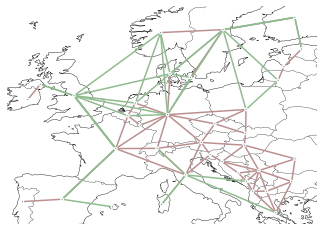

In [37]:
no.plot()

In [38]:
print(no.all_components)
no.components["Generator"]["attrs"]


{'Transformer', 'GlobalConstraint', 'Load', 'Link', 'StorageUnit', 'Carrier', 'Store', 'ShuntImpedance', 'Line', 'Bus', 'SubNetwork', 'LineType', 'Generator', 'TransformerType'}


,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for PF, must be ""PQ"", ""...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not yet implem...,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits in OPF.,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity p_nom to be extended ...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If p_nom is extendable in OPF, set its minimum...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If p_nom is extendable in OPF, set its maximum...",Input (optional),True,False,<class 'float'>,float64
p_min_pu,static or series,per unit,0.0,The minimum output for each snapshot per unit ...,Input (optional),True,True,<class 'float'>,float64


### Generators

Power generator.

- **p_max_pu**: per unit limit, given the weather potentials at the site, time-varying. The maximum output for each snapshot per unit of p_nom for the OPF (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
- **p_min_pu**: The minimum output for each snapshot per unit of p_nom for the OPF (e.g. for variable renewable generators this can change due to weather conditions and compulsory feed-in; for conventional generators it represents a minimal dispatch). Note that if comittable is False and p_min_pu > 0, this represents a must-run condition.
- **p_nom**: nominal power for limits in OPF in MW
- **p_nom\*p_max_pu** limits maximum possible power
- **p_nom_opt**: optimal capacities for generators
- **p_nom_extendable**: Switch to allow capacity p_nom to be extended in OPF.
- **p_nom_min, p_nom_max**: If p_nom is extendable in OPF, set it minimum and maximum value
- **carrier**: Prime mover energy carrier (e.g. coal, gas, wind, solar); required for global constraints on primary energy in OPF
- **marginal_cost**: Marginal cost of production of 1 MWH in currency/MWh (input)
- **capital_cost**: Capital cost of extending p_nom by 1 MW. currency/MW
- **efficiency**: Ratio between primary energy and electrical energy, e.g. takes value 0.4 MWh_elec/MWh_thermal for gas. This is required for global constraints on primary energy in OPF. It is 1 for RE

- **p**: Active power at bus (positive if net generation) in MW --> Output
- **p_nom_opt**: Optimised nominal power in MW
- Maximum dispatchable active power is **p_max_pu\*p_nom**
- No unit commitment/optimization and therefore no consideration start_up_cost, shut_down_cost, min_up_time, min_down_time, up_time_before, down_time_before, ramp_limit_start_up and ramp_limit_shut_down
- Ramp_limit_up and ramp_limit_down is NaN and ignored

Generators attach to a single bus and can feed in power. It converts energy from its carrier to the carrier-type of the bus to which it is attached.
Generators with time-varying limits are like variable weather-dependent renewable generators. The time series p_max_pu, stored as a series in ```network.generators_t.p_max_pu[gen_name]```, dictates the active power availability for each snapshot per unit of the nominal power p_nom and another time series p_min_pu which dictates the minimum dispatch.

This time series is then multiplied by p_nom to get the available power dispatch, which is the maximum that may be dispatched. The actual dispatch ```p```, stored in ```network.generators_t.p[gen_name]```, may be below this value, e.g.

In [39]:
no.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.025517,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.235920,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025056,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.010623,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.019365,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.498231,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911082,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.024622,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [40]:
no.generators.groupby("carrier").sum()

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,p_nom_extendable,p_max_pu,p_nom_opt,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000e+00,152678.256007,2.280666e+06,152678.256007,1274.670540,12.595922,0,27.00,152678.256007,...,0.0,0.0,0,0,27,0,0.0,0.0,27.0,27.0
OCGT,NaN,0.000000e+00,25967.043396,3.306419e+05,25967.043396,408.762822,2.477865,7,7.00,25967.043396,...,0.0,0.0,0,0,7,0,0.0,0.0,7.0,7.0
biomass,NaN,0.000000e+00,17562.651976,3.058169e+06,17562.651976,164.642521,5.148000,0,11.00,17562.651976,...,0.0,0.0,0,0,11,0,0.0,0.0,11.0,11.0
coal,NaN,0.000000e+00,68990.961852,2.572749e+06,68990.961852,506.382234,9.735809,0,21.00,68990.961852,...,0.0,0.0,0,0,21,0,0.0,0.0,21.0,21.0
lignite,NaN,0.000000e+00,48545.997638,2.137706e+06,48545.997638,202.467819,6.547579,0,15.00,48545.997638,...,0.0,0.0,0,0,15,0,0.0,0.0,15.0,15.0
nuclear,NaN,0.000000e+00,110269.100000,6.614961e+06,110269.100000,253.682582,5.049750,0,12.61,110269.100000,...,0.0,0.0,0,0,15,0,0.0,0.0,15.0,15.0
offwind-ac,6.004010e+05,1.995715e+05,12227.239270,5.236699e+06,12227.239270,0.649027,26.000000,26,26.00,76084.353962,...,0.0,0.0,0,0,26,0,0.0,0.0,26.0,26.0
offwind-dc,4.234966e+05,1.975903e+05,12768.953595,4.292713e+06,12768.953595,0.477153,19.000000,19,19.00,94704.158478,...,0.0,0.0,0,0,19,0,0.0,0.0,19.0,19.0
oil,NaN,0.000000e+00,7797.316630,4.970493e+05,7797.316630,1693.073711,5.022859,0,13.00,7797.316630,...,0.0,0.0,0,0,13,0,0.0,0.0,13.0,13.0


### Storage Units
Storage unit with fixed nominal-energy-to-nominal-power ratio.
Storage units attach to a single bus and are used for inter-temporal power shifting. Each storage unit has a time-varying state of charge and various efficiencies. The nominal energy is given as a fixed ratio max_hours of the nominal power. If you want to optimise the storage energy capacity independently from the storage power capacity, you should use a fundamental Store component (see below) attached with two Link components, one for charging and one for discharging.

**Outputs:**
- **p**: active power at bus (positive if net generation
- **p_dispatch**: active power dispatch at bus
- **p_store**: active power charging at bus
- **state_of_charge**: State of charge as calculated by the OPF in MWh
- **spill**: spillage for each snapshot in MW
- **p_nom_opt**: Optimal power output unchanged because the units are not extendable

In [41]:
no.storage_units

,cyclic_state_of_charge,bus,efficiency_dispatch,efficiency_store,carrier,capital_cost,max_hours,p_nom,p_min_pu,p_nom_max,...,q_set,sign,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
AL1 0 hydro,True,AL1 0,0.900000,0.000000,hydro,160627.143522,6.000000,1421.700000,0.0,NaN,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT1 0 PHS,True,AT1 0,0.866025,0.866025,PHS,160627.143522,6.000000,7036.800000,-1.0,NaN,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT1 0 hydro,True,AT1 0,0.900000,0.000000,hydro,160627.143522,1139.298480,2730.200000,0.0,NaN,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BA1 0 PHS,True,BA1 0,0.866025,0.866025,PHS,160627.143522,6.000000,440.000000,-1.0,inf,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BA1 0 hydro,True,BA1 0,0.900000,0.000000,hydro,160627.143522,1474.491301,1695.500000,0.0,NaN,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BE1 0 PHS,True,BE1 0,0.866025,0.866025,PHS,160627.143522,6.000000,1308.000000,-1.0,inf,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BE1 0 hydro,True,BE1 0,0.900000,0.000000,hydro,160627.143522,15646.021227,12.782803,0.0,inf,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BG1 0 PHS,True,BG1 0,0.866025,0.866025,PHS,160627.143522,6.000000,864.000000,-1.0,inf,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
BG1 0 hydro,True,BG1 0,0.900000,0.000000,hydro,160627.143522,1961.226551,2039.540000,0.0,NaN,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0


In [42]:
no_storage_p_nom = no.storage_units.groupby("carrier")["p_nom"].sum()
n4_storage_p_nom = n4.storage_units.groupby("carrier")["p_nom"].sum()
n6_storage_p_nom = n6.storage_units.groupby("carrier")["p_nom"].sum()
print(no_storage_p_nom)
print(n4_storage_p_nom)
print(n6_storage_p_nom)

carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom, dtype: float64
carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom, dtype: float64
carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom, dtype: float64


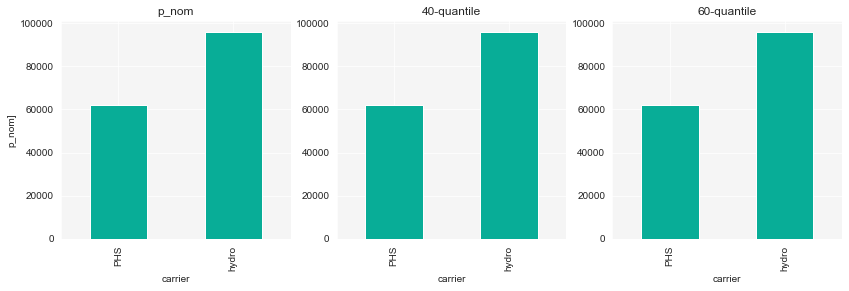

In [43]:
fig, ax = plt.subplots(1,3, figsize=(14,4))

for ax_i in [ax[0], ax[1], ax[2]]:
    ax_i.set_facecolor("whitesmoke")
#    ax_i.set_ylim([140, 560])

storage = ['PHS','hydro']
no_storage_p_nom.plot.bar(color=no.carriers.loc[storage].color, ax=ax[0])
n4_storage_p_nom.plot.bar(color=no.carriers.loc[storage].color, ax=ax[1])
n6_storage_p_nom.plot.bar(color=no.carriers.loc[storage].color, ax=ax[2])

ax[0].set_ylabel("p_nom]")

ax[0].set_title("p_nom")
ax[1].set_title("40-quantile")
ax[2].set_title("60-quantile")

plt.show()

In [44]:
no_storage_p_nom_opt = no.storage_units.groupby("carrier")["p_nom_opt"].sum()
n4_storage_p_nom_opt = n4.storage_units.groupby("carrier")["p_nom_opt"].sum()
n6_storage_p_nom_opt = n6.storage_units.groupby("carrier")["p_nom_opt"].sum()
print(no_storage_p_nom_opt)
print(n4_storage_p_nom_opt)
print(n6_storage_p_nom_opt)

carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom_opt, dtype: float64
carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom_opt, dtype: float64
carrier
PHS      61896.735000
hydro    96153.075434
Name: p_nom_opt, dtype: float64


In [45]:
no.storage_units_t.p

StorageUnit,AL1 0 hydro,AT1 0 PHS,AT1 0 hydro,BA1 0 PHS,BA1 0 hydro,BE1 0 PHS,BE1 0 hydro,BG1 0 PHS,BG1 0 hydro,CH1 0 PHS,...,PT1 0 hydro,RO1 0 hydro,RS1 0 PHS,RS1 0 hydro,SE2 0 PHS,SE2 0 hydro,SI1 0 PHS,SI1 0 hydro,SK1 0 PHS,SK1 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1243.359691,-1143.445472,0.007459,10.121198,1695.499496,-521.186882,0.002886,12.048312,2039.539434,19.121017,...,589.967352,4451.739559,10.795954,426.097182,-91.989910,0.013570,3.584645,197.999657,-145.360013,0.004584
2013-01-01 01:00:00,368.439521,-993.322138,0.007463,0.002050,1695.499374,-596.059264,0.002888,0.002566,2039.539294,-0.000220,...,566.080029,4451.739420,0.002287,275.616678,-91.989906,0.013557,0.001379,197.999588,-186.303395,0.004606
2013-01-01 02:00:00,0.001634,-1588.922470,0.007464,-0.004995,1695.499010,-810.822069,0.002888,-0.005507,2039.538869,-0.118669,...,529.067219,4451.739002,-0.005343,0.000999,-91.989900,0.013551,-0.003520,197.999408,-379.360168,0.004615
2013-01-01 03:00:00,0.001369,-1215.558041,0.007464,-0.009028,1695.498785,-96.723023,0.002887,-0.010642,2039.538600,-3317.243724,...,502.902915,4451.738741,-0.009869,0.000823,-91.989901,0.013547,-0.006674,197.999312,-444.219434,0.004619
2013-01-01 04:00:00,0.001354,-1625.617751,0.007464,-0.004562,1695.498763,0.041422,0.003037,-0.005004,2039.538573,-2430.942993,...,482.444746,4451.738716,-0.004850,0.000803,-91.989901,0.013552,-0.003215,197.999304,-643.043261,0.004621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1418.159154,699.925210,0.007416,340.462714,1695.499497,-322.381020,0.002889,129.228203,2039.539435,246.427703,...,721.091172,4451.739560,460.450571,426.097256,-5.109446,1497.937093,141.598944,197.999658,0.047735,0.007617
2013-12-31 20:00:00,1418.145634,235.359412,0.007430,227.137712,1695.499497,-294.513253,0.002888,147.716774,2039.539435,136.337719,...,679.553304,4451.739560,444.692519,426.097241,-5.127957,1501.034945,45.363245,197.999658,-0.289491,0.004421
2013-12-31 21:00:00,167.560130,520.909864,0.007441,1.002233,1695.499497,-212.054690,0.002888,860.757498,2039.539435,3.003294,...,633.931305,4451.739560,9.790909,426.097222,-5.148616,1593.550960,0.165215,197.999657,-28.160765,0.004400


In [46]:
no.storage_units_t.state_of_charge.sum(axis=1)

snapshot
2013-01-01 00:00:00    1.299087e+08
2013-01-01 01:00:00    1.299121e+08
2013-01-01 02:00:00    1.299191e+08
2013-01-01 03:00:00    1.299288e+08
2013-01-01 04:00:00    1.299390e+08
                           ...     
2013-12-31 19:00:00    1.299024e+08
2013-12-31 20:00:00    1.299008e+08
2013-12-31 21:00:00    1.299027e+08
2013-12-31 22:00:00    1.299047e+08
2013-12-31 23:00:00    1.299079e+08
Length: 8760, dtype: float64

In [47]:
no_p_storage_24 = no.storage_units_t.p.sum(axis=1)[:24]
n4_p_storage_24 = n4.storage_units_t.p.sum(axis=1)[:24]
n6_p_storage_24 = n6.storage_units_t.p.sum(axis=1)[:24]

no_state_of_charge_24 = no.storage_units_t.state_of_charge.sum(axis=1)[:24]
n4_state_of_charge_24 = n4.storage_units_t.state_of_charge.sum(axis=1)[:24]
n6_state_of_charge_24 = n6.storage_units_t.state_of_charge.sum(axis=1)[:24]

no_p_storage = no.storage_units_t.p.sum(axis=1)
n4_p_storage = n4.storage_units_t.p.sum(axis=1)
n6_p_storage = n6.storage_units_t.p.sum(axis=1)

no_state_of_charge = no.storage_units_t.state_of_charge.sum(axis=1)
n4_state_of_charge = n4.storage_units_t.state_of_charge.sum(axis=1)
n6_state_of_charge = n6.storage_units_t.state_of_charge.sum(axis=1)



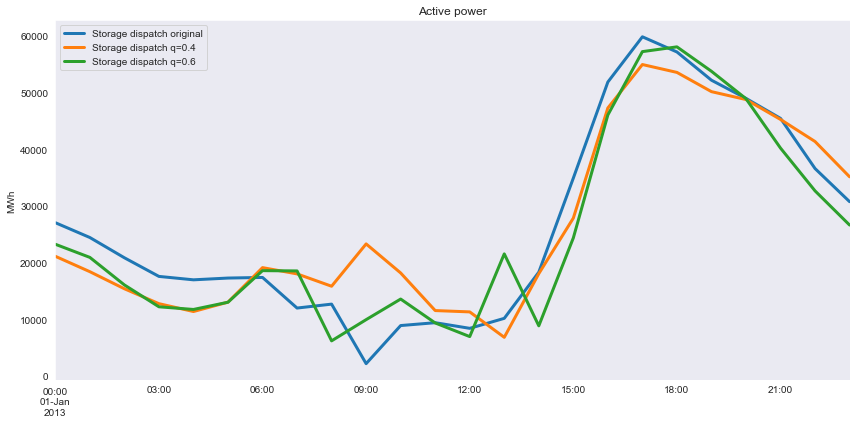

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

no_p_storage_24.plot(label="Storage dispatch original", ax=ax, linewidth=3)
n4_p_storage_24.plot(label="Storage dispatch q=0.4", ax=ax, linewidth=3)
n6_p_storage_24.plot(label="Storage dispatch q=0.6", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
ax.set_title("Active power")
fig.tight_layout()

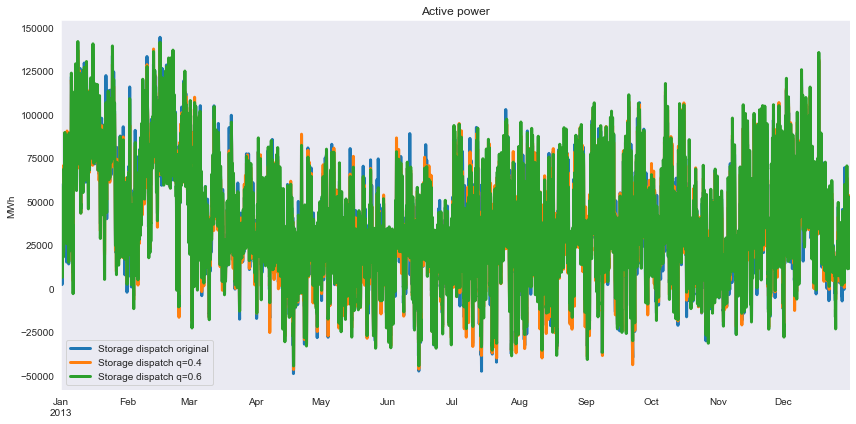

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

no_p_storage.plot(label="Storage dispatch original", ax=ax, linewidth=3)
n4_p_storage.plot(label="Storage dispatch q=0.4", ax=ax, linewidth=3)
n6_p_storage.plot(label="Storage dispatch q=0.6", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
ax.set_title("Active power")
fig.tight_layout()

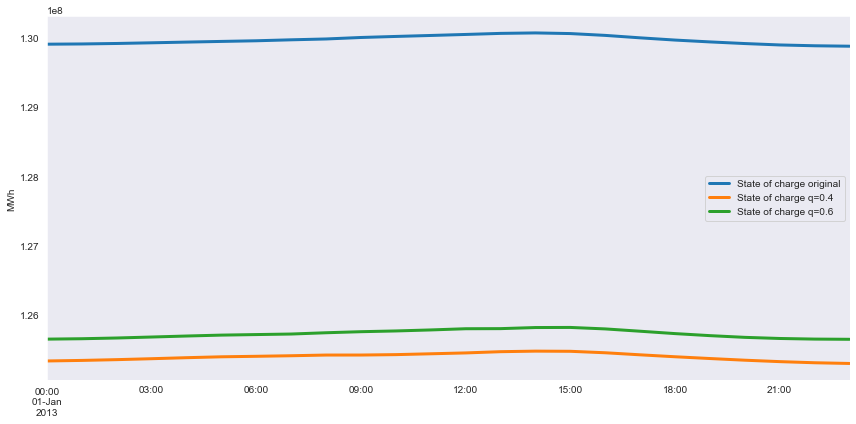

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))

no_state_of_charge_24.plot(label="State of charge original", ax=ax, linewidth=3)
n4_state_of_charge_24.plot(label="State of charge q=0.4", ax=ax, linewidth=3)
n6_state_of_charge_24.plot(label="State of charge q=0.6", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
fig.tight_layout()

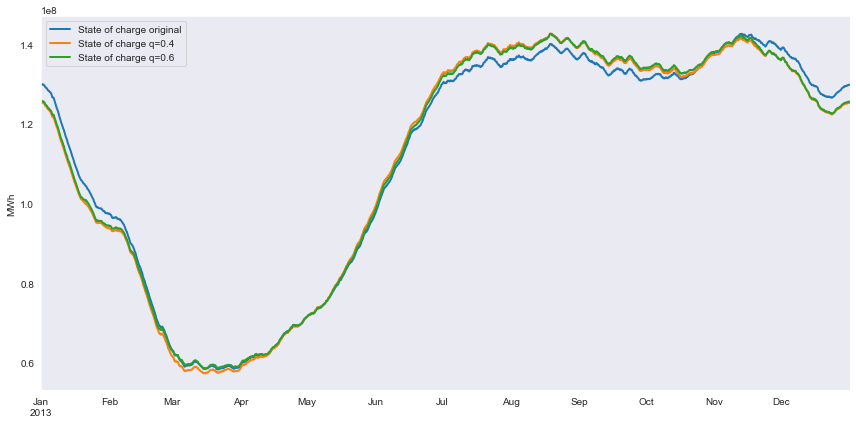

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

no_state_of_charge.plot(label="State of charge original", ax=ax, linewidth=2)
n4_state_of_charge.plot(label="State of charge q=0.4", ax=ax, linewidth=2)
n6_state_of_charge.plot(label="State of charge q=0.6", ax=ax, linewidth=2)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
fig.tight_layout()

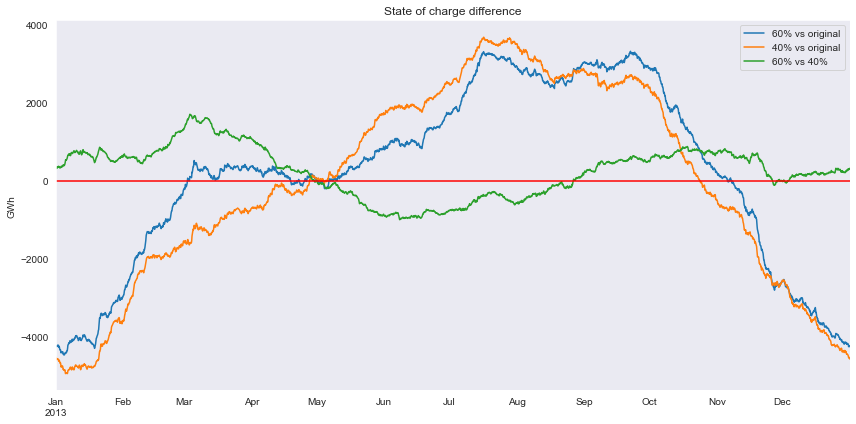

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

state_of_charge_diff_6o = (n6_state_of_charge - no_state_of_charge)/1e3
state_of_charge_diff_4o = (n4_state_of_charge - no_state_of_charge)/1e3
state_of_charge_diff_64 = (n6_state_of_charge - n4_state_of_charge)/1e3

state_of_charge_diff_6o.plot(label="60% vs original", ax=ax)
state_of_charge_diff_4o.plot(label="40% vs original", ax=ax)
state_of_charge_diff_64.plot(label="60% vs 40%", ax=ax)

plt.axhline(y=0, color='r', linestyle='-')

# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ticklabel_format(style='plain', axis='y')
ax.legend()
ax.grid()
ax.set_ylabel("GWh")
ax.set_xlabel("")
ax.set_title("State of charge difference")
fig.tight_layout()

In [53]:
no_marginal_cost = no.storage_units.marginal_cost
n4_marginal_cost = n4.storage_units.marginal_cost
n6_marginal_cost = n6.storage_units.marginal_cost
index = ["no marginal cost", "n4 marginal cost", "n6 marginal cost"]
marginal_costs = pd.DataFrame([no_marginal_cost, n4_marginal_cost, n6_marginal_cost], index=index)
marginal_costs

StorageUnit,AL1 0 hydro,AT1 0 PHS,AT1 0 hydro,BA1 0 PHS,BA1 0 hydro,BE1 0 PHS,BE1 0 hydro,BG1 0 PHS,BG1 0 hydro,CH1 0 PHS,...,PT1 0 hydro,RO1 0 hydro,RS1 0 PHS,RS1 0 hydro,SE2 0 PHS,SE2 0 hydro,SI1 0 PHS,SI1 0 hydro,SK1 0 PHS,SK1 0 hydro
no marginal cost,0.009899,0.009506,0.010759,0.009824,0.010319,0.010997,0.009755,0.010344,0.009536,0.010364,...,0.009087,0.009904,0.010924,0.009896,0.010909,0.010248,0.010168,0.009363,0.009664,0.009257
n4 marginal cost,0.009815,0.010902,0.010391,0.009064,0.009434,0.009752,0.010814,0.010001,0.010644,0.009124,...,0.010309,0.009883,0.010518,0.009687,0.010726,0.009857,0.009762,0.010497,0.009272,0.009323
n6 marginal cost,0.009809,0.009302,0.010344,0.009939,0.009378,0.009989,0.010722,0.010484,0.010340,0.010499,...,0.010117,0.010065,0.010096,0.010741,0.009165,0.010359,0.009468,0.009846,0.009297,0.009844


In [54]:
# fig, ax = plt.subplots(figsize=(12, 6))
#
# no_marginal_cost.plot(label="marginal costs original", ax=ax)
# n4_marginal_cost.plot(label="marginal costs 40% quantil", ax=ax)
# n6_marginal_cost.plot(label="marginal costs 60% quantil", ax=ax)
#
# #plt.ticklabel_format(style='plain', axis='y')
# ax.legend()
# ax.grid()
# ax.set_ylabel("GWh")
# # ax.set_xlabel("")
# ax.set_title("Marginal Costs")

### Store
Generic store, whose capacity may be optimised.

The Store connects to a single bus. It is a more fundamental component for storing energy only (it cannot convert between energy carriers). It inherits its energy carrier from the bus to which it is attached.
The Store has controls and optimisation on the size of its energy capacity, but not it’s power output; to control the power output, you must put a link in front of it

- **bus**: Name of bus to wich store is attached
- **e_nom**: nominal energy capacity

**Outputs**
- **p**: active power at bus (positive if net generation)
- **e**: Energy as calculated by the OPF in MWH
- **e_nom_opt**: Optimised nominal energy capacity outputed by OPF in MWh

In [84]:
no.stores_t.e

Store,AL1 0 H2,AT1 0 H2,BA1 0 H2,BE1 0 H2,BG1 0 H2,CH1 0 H2,CZ1 0 H2,DE1 0 H2,DK1 0 H2,DK2 0 H2,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,67096.721675,1.239500e+06,27.971872,787272.910455,36.572217,49.378531,36.044286,1.715201e+06,422681.701135,311997.528718,...,0.002890,0.075663,0.034202,0.084815,2125.479226,0.002645,0.002704,0.044565,0.002005,0.068432
2013-01-01 01:00:00,67096.720210,1.245874e+06,27.970705,790269.391918,36.571325,49.323244,36.242906,1.724287e+06,424607.675788,314488.003662,...,0.001205,0.077462,0.033937,0.085537,1879.286728,0.001168,0.001162,0.070018,0.000844,0.071176
2013-01-01 02:00:00,67096.720840,1.252248e+06,27.972432,793265.873453,36.572548,49.642795,36.441407,1.733373e+06,425425.717747,316990.886567,...,0.003566,0.079833,0.033788,0.085933,1647.262886,0.003204,0.003242,0.094522,0.002424,0.072438
2013-01-01 03:00:00,67096.723420,1.258622e+06,27.989806,796262.355034,36.580595,49.968377,36.640027,1.742460e+06,425787.598274,319497.245939,...,0.009009,0.082724,0.033848,0.086135,1417.741153,0.007133,0.007473,0.119159,0.005729,0.072524
2013-01-01 04:00:00,67096.726346,1.264996e+06,28.022830,799258.834709,36.592193,50.294219,36.838713,1.751546e+06,426031.164992,321965.697527,...,0.011074,0.081691,0.034081,0.086216,1183.413504,0.008248,0.008708,0.144707,0.006804,0.071680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,67096.752320,1.207649e+06,27.987264,772290.505299,36.582339,52.893760,35.057976,1.669769e+06,412631.828868,302640.435698,...,2076.440188,0.074566,0.034023,0.086753,3430.050236,0.316729,0.310230,0.072589,23.138379,0.008561
2013-12-31 20:00:00,67096.746330,1.214014e+06,27.984201,775286.986404,36.580412,52.189423,35.254431,1.678855e+06,414328.122605,303905.585561,...,1981.279988,0.075033,0.034215,0.086569,3110.208979,0.270462,0.266652,0.064924,2.162289,0.029310
2013-12-31 21:00:00,67096.740221,1.220378e+06,27.981129,778283.467381,36.578441,51.484756,35.451258,1.687942e+06,416131.348832,305397.465899,...,924.818814,0.075639,0.034359,0.085985,2835.018678,0.219576,0.220042,0.054499,2.034013,0.045609


In [85]:
n4.stores_t.e

Store,AL1 0 H2,AT1 0 H2,BA1 0 H2,BE1 0 H2,BG1 0 H2,CH1 0 H2,CZ1 0 H2,DE1 0 H2,DK1 0 H2,DK2 0 H2,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,46126.777897,1.306026e+06,32.200087,546671.790083,50.078267,272.617308,83.914003,1.467377e+06,424548.924581,235837.560996,...,740.165900,0.151349,0.078982,0.157755,1309.273478,0.298624,0.163103,0.177230,0.051006,0.050927
2013-01-01 01:00:00,46126.771604,1.312476e+06,32.198601,549112.224032,50.074986,269.566075,84.234950,1.475991e+06,427864.408500,237912.687518,...,0.016884,0.152571,0.077011,0.159889,1309.251589,0.017075,0.017093,0.170393,0.012136,0.082653
2013-01-01 02:00:00,46126.768683,1.318925e+06,32.198072,551552.658004,50.073115,271.795114,84.556193,1.484606e+06,431075.937590,239993.970749,...,0.014517,0.154389,0.075826,0.161090,1309.229257,0.014896,0.014871,0.176069,0.010995,0.109177
2013-01-01 03:00:00,46126.765795,1.325374e+06,32.197558,553993.091959,50.071283,274.065937,84.877704,1.493221e+06,434011.276390,242078.946075,...,0.009509,0.156053,0.075514,0.161790,1309.206994,0.010598,0.010566,0.184914,0.007989,0.131468
2013-01-01 04:00:00,46126.764358,1.331822e+06,32.198034,556433.523310,50.070386,276.415329,85.199368,1.501836e+06,436511.626231,244160.097328,...,0.011699,0.155884,0.075516,0.162108,1309.185031,0.011164,0.011312,0.180768,0.009883,0.150463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,46126.810062,1.274134e+06,32.207698,534469.622718,50.094188,292.676477,82.354405,1.424303e+06,409579.777533,226975.171021,...,2247.053962,0.150916,0.071654,0.161566,1506.733703,0.888842,0.574359,0.175888,1192.984757,0.121140
2013-12-31 20:00:00,46126.803689,1.280486e+06,32.206166,536910.055990,50.090995,288.441511,82.663556,1.432918e+06,412574.229974,228369.195654,...,2175.111458,0.153106,0.073736,0.161046,1309.357915,0.802367,0.501258,0.175655,703.480457,0.106606
2013-12-31 21:00:00,46126.797283,1.286808e+06,32.204635,539350.488992,50.087811,284.207914,82.973086,1.441533e+06,414886.463244,229949.862901,...,2117.071128,0.152448,0.075713,0.159580,1309.336411,0.716048,0.427054,0.174578,196.956241,0.085975


In [55]:
no.stores
# no.stores_t

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,marginal_cost,e_nom_opt,type,e_nom,e_nom_min,...,e_max_pu,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,standing_loss,build_year,lifetime
Store,,,,,,,,,,,,,,,,,,,,,
AL1 0 H2,AL1 0 H2,H2,True,True,796.283619,0.010704,8.522561e+04,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
AT1 0 H2,AT1 0 H2,H2,True,True,796.283619,0.009121,1.800045e+06,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
BA1 0 H2,BA1 0 H2,H2,True,True,796.283619,0.010340,4.036322e+01,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
BE1 0 H2,BE1 0 H2,H2,True,True,796.283619,0.010300,8.798535e+05,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
BG1 0 H2,BG1 0 H2,H2,True,True,796.283619,0.009445,6.396653e+01,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 battery,RO1 0 battery,battery,True,True,15877.883774,0.009810,6.740054e-01,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
RS1 0 battery,RS1 0 battery,battery,True,True,15877.883774,0.010962,6.521373e-01,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf
SE2 0 battery,SE2 0 battery,battery,True,True,15877.883774,0.009661,1.887224e-01,,0.0,0.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0,inf


### Loads
The power (p,q) of loads is positive if withdrawing power from bus, negative if injecting power into busPQ power consumer.
PQ power consumer.
- **p_set**: Active power consumption (positive if the load is consuming power) in MW *(input)*
- **p**: active power at bus (positive if net load) *(output)*

In [90]:
n4.loads_t.p_set.sum(axis=1)

snapshot
2013-01-01 00:00:00    315195.969703
2013-01-01 01:00:00    301523.187746
2013-01-01 02:00:00    286603.410192
2013-01-01 03:00:00    277709.058154
2013-01-01 04:00:00    274192.758462
                           ...      
2013-12-31 19:00:00    375086.008997
2013-12-31 20:00:00    356143.574219
2013-12-31 21:00:00    350239.572049
2013-12-31 22:00:00    340044.637951
2013-12-31 23:00:00    330911.160614
Length: 8760, dtype: float64

In [92]:
n6.loads_t.p.sum(axis=1)

snapshot
2013-01-01 00:00:00    315195.969703
2013-01-01 01:00:00    301523.187746
2013-01-01 02:00:00    286603.410192
2013-01-01 03:00:00    277709.058154
2013-01-01 04:00:00    274192.758462
                           ...      
2013-12-31 19:00:00    375086.008997
2013-12-31 20:00:00    356143.574219
2013-12-31 21:00:00    350239.572049
2013-12-31 22:00:00    340044.637951
2013-12-31 23:00:00    330911.160614
Length: 8760, dtype: float64

In [56]:
no.loads_t.p

Load,AL1 0,AT1 0,BA1 0,BE1 0,BG1 0,CH1 0,CZ1 0,DE1 0,DK1 0,DK2 0,...,MK1 0,NL1 0,NO2 0,PL1 0,PT1 0,RO1 0,RS1 0,SE2 0,SI1 0,SK1 0
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,683.702703,5946.001049,1348.0,8096.0,4388.8889,6002.190892,5618.0,38563.722227,1893.156111,1445.843889,...,1234.0,10600.0,14367.171706,13134.0,4750.0,5779.0,5580.0,14610.0,1590.998951,2785.0
2013-01-01 01:00:00,634.945946,5699.805271,1269.0,7607.0,4166.6667,5795.279436,5574.0,37006.672319,1767.852877,1350.147123,...,1146.0,10051.0,14185.888622,12475.0,4557.0,5560.0,5288.0,14343.0,1522.194729,2658.0
2013-01-01 02:00:00,593.391892,5394.858229,1209.0,7218.0,3985.8586,5453.740949,5451.0,35527.069439,1683.939398,1286.060602,...,1071.0,9519.0,14024.098343,11994.0,4262.0,5403.0,4963.0,14117.0,1480.141771,2571.0
2013-01-01 03:00:00,554.054054,5375.274474,1169.0,7029.0,3829.2929,5085.388017,5373.0,34978.592145,1621.571272,1238.428728,...,1000.0,9188.0,14016.301221,11843.0,4002.0,5348.0,4673.0,13959.0,1462.725526,2555.0
2013-01-01 04:00:00,555.162162,5443.351337,1155.0,7023.0,3794.9495,4963.612980,5260.0,34373.851483,1613.633511,1232.366489,...,1002.0,9125.0,14034.819385,11709.0,3852.0,5325.0,4515.0,14228.0,1476.648663,2559.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,710.297297,6921.458561,1615.0,9167.0,5216.1616,6067.275696,6252.0,50441.495019,2147.731462,1640.268538,...,1282.0,12774.0,15062.090193,15957.0,6484.0,6304.0,6026.0,16356.0,1725.541439,2958.0
2013-12-31 20:00:00,665.418919,6582.006807,1555.0,8984.0,4767.6768,6060.834106,6048.0,48879.607927,2084.796353,1592.203647,...,1201.0,11987.0,14681.980501,15041.0,5869.0,6094.0,5599.0,15890.0,1600.993193,2851.0
2013-12-31 21:00:00,683.148649,6859.909617,1493.0,9405.0,4680.8081,6223.208832,5950.0,49117.055646,1985.574334,1516.425666,...,1233.0,11472.0,14412.005156,14595.0,5543.0,5894.0,5324.0,15455.0,1562.090383,2821.0


**Less stored energy in sommer** for 60% Quantil. Predictions differ more for solar, so there is a bigger difference in those months?

array(['AL1 0', 'AT1 0', 'BA1 0', 'BE1 0', 'BG1 0', 'CH1 0', 'CZ1 0',
       'DE1 0', 'DK1 0', 'DK2 0', 'EE6 0', 'ES1 0', 'ES4 0', 'FI2 0',
       'FR1 0', 'GB0 0', 'GB5 0', 'GR1 0', 'HR1 0', 'HU1 0', 'IE5 0',
       'IT1 0', 'IT3 0', 'LT6 0', 'LU1 0', 'LV6 0', 'ME1 0', 'MK1 0',
       'NL1 0', 'NO2 0', 'PL1 0', 'PT1 0', 'RO1 0', 'RS1 0', 'SE2 0',
       'SI1 0', 'SK1 0', 'AL1 0 H2', 'AT1 0 H2', 'BA1 0 H2', 'BE1 0 H2',
       'BG1 0 H2', 'CH1 0 H2', 'CZ1 0 H2', 'DE1 0 H2', 'DK1 0 H2',
       'DK2 0 H2', 'EE6 0 H2', 'ES1 0 H2', 'ES4 0 H2', 'FI2 0 H2',
       'FR1 0 H2', 'GB0 0 H2', 'GB5 0 H2', 'GR1 0 H2', 'HR1 0 H2',
       'HU1 0 H2', 'IE5 0 H2', 'IT1 0 H2', 'IT3 0 H2', 'LT6 0 H2',
       'LU1 0 H2', 'LV6 0 H2', 'ME1 0 H2', 'MK1 0 H2', 'NL1 0 H2',
       'NO2 0 H2', 'PL1 0 H2', 'PT1 0 H2', 'RO1 0 H2', 'RS1 0 H2',
       'SE2 0 H2', 'SI1 0 H2', 'SK1 0 H2', 'AL1 0 battery',
       'AT1 0 battery', 'BA1 0 battery', 'BE1 0 battery', 'BG1 0 battery',
       'CH1 0 battery', 'CZ1 0 battery',

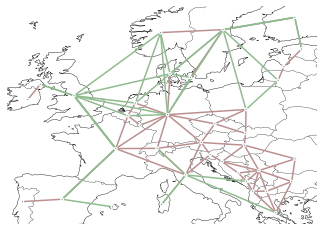

In [57]:
n4.plot()
n4.generators
n4.buses.index.values

In [58]:
no.transformer_types

,f_nom,s_nom,v_nom_0,v_nom_1,vsc,vscr,pfe,i0,phase_shift,tap_side,tap_neutral,tap_min,tap_max,tap_step,references
TransformerType,,,,,,,,,,,,,,,
0.25 MVA 10/0.4 kV,50.0,0.25,10.0,0.4,4.00,1.2000,0.60,0.2400,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.25 MVA 20/0.4 kV,50.0,0.25,20.0,0.4,6.00,1.4400,0.80,0.3200,150.0,0,0,-2,2,2.5,pandapowe;Oswald - Transformatoren - Vorlesung...
0.4 MVA 10/0.4 kV,50.0,0.40,10.0,0.4,4.00,1.3250,0.95,0.2375,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.4 MVA 20/0.4 kV,50.0,0.40,20.0,0.4,6.00,1.4250,1.35,0.3375,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.63 MVA 10/0.4 kV,50.0,0.63,10.0,0.4,4.00,1.0794,1.18,0.1873,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.63 MVA 20/0.4 kV,50.0,0.63,20.0,0.4,6.00,1.2060,1.65,0.2619,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
100 MVA 220/110 kV,50.0,100.00,220.0,110.0,12.00,0.2600,55.00,0.0600,0.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...
160 MVA 380/110 kV,50.0,160.00,380.0,110.0,12.20,0.2500,60.00,0.0600,0.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...
25 MVA 110/10 kV,50.0,25.00,110.0,10.0,10.04,0.2760,28.51,0.0730,150.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...


### Bus
Electrically fundamental node where x-port objects attach.
The power (p0,q0) at bus0 of a branch is positive if the branch is withdrawing power from bus0, i.e. bus0 is injecting into branch
**p**: active power at bus (positive if net generation at bus) in MW
v_ang Voltage angle changes for the different networks

In [59]:
no.buses_t.p

Bus,AL1 0,AT1 0,BA1 0,BE1 0,BG1 0,CH1 0,CZ1 0,DE1 0,DK1 0,DK2 0,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,578.708477,-15045.128638,357.766240,452.010242,-548.098403,-2136.104411,-6652.125761,8219.351423,2568.763031,2377.333255,...,-2.852219e-09,-1.899492e-09,-1.651990e-09,-1.578413e-09,-1.837710e-09,-1.862988e-09,-6.554264e-10,-1.715587e-09,6.366285e-09,-1.173393e-09
2013-01-01 01:00:00,-252.625307,-14648.710070,426.502563,819.935468,-339.053628,-4827.759096,-6604.318069,10769.996394,2525.135475,2377.333245,...,-3.246635e-09,-1.588460e-09,-1.786157e-09,-1.539374e-09,-1.787828e-09,-1.804461e-09,-2.096967e-09,-1.652427e-09,1.397874e-08,-1.868268e-09
2013-01-01 02:00:00,-579.515812,-14939.393021,486.488192,892.791491,-165.704402,-4571.864104,-6346.032362,10389.266427,2401.913291,2377.333240,...,-2.942841e-09,-1.678752e-09,-1.382720e-09,-1.640177e-09,-1.699025e-09,-1.614355e-09,-1.803672e-09,-1.626266e-09,-1.929051e-08,-2.704418e-09
2013-01-01 03:00:00,-540.177833,-14546.403138,526.461926,868.937359,-9.154160,-7520.011271,-5993.410839,13549.563326,2051.744729,2377.333237,...,-3.130244e-09,-1.526292e-09,-1.516117e-09,-1.598102e-09,-7.799031e-10,-1.411873e-09,-2.156093e-09,-1.605219e-09,7.812748e-09,-2.014479e-09
2013-01-01 04:00:00,-541.279057,-15024.430751,540.450094,-1901.473060,25.193867,-6510.774746,-5714.539202,13475.534747,1532.701217,2377.333240,...,-2.104829e-09,-2.072711e-09,-2.310013e-09,-1.652809e-09,-1.578816e-09,-1.642820e-09,-1.846927e-09,-1.638023e-09,-2.332968e-08,-3.176866e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1618.040775,-14141.665058,421.039312,-1036.621100,-1239.111346,-1927.701165,-5855.525172,9314.241597,2501.825194,2377.337747,...,-6.374025e-09,-1.406004e-09,-1.416244e-09,-1.621914e-09,-1.282494e-09,-1.466769e-09,-1.533864e-09,-1.687383e-09,1.659291e-08,-1.636907e-09
2013-12-31 20:00:00,963.738180,-14271.311637,367.716603,-2032.490499,-774.130255,-2031.058866,-6316.878517,9526.516039,2509.484002,2377.337748,...,-3.514193e-09,-1.588819e-09,-1.710595e-09,-1.581270e-09,1.620615e-10,-1.950673e-09,-1.586455e-09,-1.805947e-09,-2.164335e-08,-1.137750e-09
2013-12-31 21:00:00,-501.149731,-14259.675282,203.579721,-2767.626582,25.986175,-2325.655803,-6491.887474,9955.999440,2520.844746,2377.337750,...,-1.920295e-09,-1.572912e-09,-1.627635e-09,-1.571571e-09,-1.342260e-09,-1.682511e-09,-1.414137e-09,-1.708909e-09,1.822393e-08,-1.506215e-09


In [60]:
no.buses_t.q

Bus
snapshot
2013-01-01 00:00:00
2013-01-01 01:00:00
2013-01-01 02:00:00
2013-01-01 03:00:00
2013-01-01 04:00:00
...
2013-12-31 19:00:00
2013-12-31 20:00:00
2013-12-31 21:00:00


In [61]:
no.buses_t.v_ang
# n4.buses_t.v_ang
# n6.buses_t.v_ang

Bus,AL1 0,AL1 0 H2,AL1 0 battery,AT1 0,AT1 0 H2,AT1 0 battery,BA1 0,BA1 0 H2,BA1 0 battery,BE1 0,...,RS1 0 battery,SE2 0,SE2 0 H2,SE2 0 battery,SI1 0,SI1 0 H2,SI1 0 battery,SK1 0,SK1 0 H2,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.960335,0.0,0.0,-0.092113,0.0,0.0,-0.819284,0.0,0.0,1.755486,...,0.0,-0.483334,0.0,0.0,-0.558176,0.0,0.0,0.107933,0.0,0.0
2013-01-01 01:00:00,-1.061828,0.0,0.0,-0.079004,0.0,0.0,-0.810540,0.0,0.0,1.744232,...,0.0,-0.456383,0.0,0.0,-0.545066,0.0,0.0,0.162817,0.0,0.0
2013-01-01 02:00:00,-1.077953,0.0,0.0,-0.108735,0.0,0.0,-0.815552,0.0,0.0,1.723569,...,0.0,-0.483334,0.0,0.0,-0.574797,0.0,0.0,0.163820,0.0,0.0
2013-01-01 03:00:00,-0.962611,0.0,0.0,-0.118790,0.0,0.0,-0.752881,0.0,0.0,1.660102,...,0.0,-0.483334,0.0,0.0,-0.584853,0.0,0.0,0.193657,0.0,0.0
2013-01-01 04:00:00,-0.900422,0.0,0.0,-0.142196,0.0,0.0,-0.722311,0.0,0.0,1.480994,...,0.0,-0.483334,0.0,0.0,-0.608259,0.0,0.0,0.201802,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,-0.820730,0.0,0.0,-0.034648,0.0,0.0,-0.789661,0.0,0.0,1.723407,...,0.0,-0.540696,0.0,0.0,-0.500710,0.0,0.0,-0.045176,0.0,0.0
2013-12-31 20:00:00,-0.837804,0.0,0.0,-0.079679,0.0,0.0,-0.771214,0.0,0.0,1.614198,...,0.0,-0.541148,0.0,0.0,-0.545741,0.0,0.0,-0.041283,0.0,0.0
2013-12-31 21:00:00,-1.035881,0.0,0.0,-0.096628,0.0,0.0,-0.809867,0.0,0.0,1.546028,...,0.0,-0.544045,0.0,0.0,-0.562691,0.0,0.0,-0.039768,0.0,0.0


In [62]:
no.buses

,v_nom,x,y,country,control,generator,carrier,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
AL1 0,380.0,19.897914,41.587568,AL,Slack,AL1 0 offwind-ac,AC,,None,1.0,0.0,inf,
AT1 0,380.0,13.604274,47.549498,AT,PQ,,AC,,None,1.0,0.0,inf,
BA1 0,380.0,18.122704,43.811367,BA,PQ,,AC,,None,1.0,0.0,inf,
BE1 0,380.0,4.617461,50.818887,BE,PQ,,AC,,None,1.0,0.0,inf,
BG1 0,380.0,24.673671,42.765271,BG,PQ,,AC,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 battery,1.0,25.091770,45.551309,RO,Slack,,battery,,None,1.0,0.0,inf,
RS1 0 battery,1.0,20.662692,44.113710,RS,Slack,,battery,,None,1.0,0.0,inf,
SE2 0 battery,1.0,16.277634,61.357761,SE,Slack,,battery,,None,1.0,0.0,inf,


### Carriers
Energy carrier, such as AC, DC, heat, wind, PV or coal. Buses have direct carriers and Generators indicate their primary energy carriers. The Carrier can track properties relevant for global constraints, such as CO2 emissions.

In [63]:
# no.buses
# no.generators
no.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
CCGT,0.187,#b20101,Combined-Cycle Gas,inf
coal,0.354,#707070,Coal,inf
onwind,0.000,#235ebc,Onshore Wind,inf
oil,0.248,#262626,Oil,inf
offwind-dc,0.000,#74c6f2,Offshore Wind (DC),inf
offwind-ac,0.000,#6895dd,Offshore Wind (AC),inf
biomass,0.000,#0c6013,Biomass,inf
geothermal,0.026,#ba91b1,Geothermal,inf
nuclear,0.000,#ff9000,Nuclear,inf


### Global Contraints
Constraints for OPF that affect many components, such as CO2 emission constraints.

In [64]:
no.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,81081.191308,NaN
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,1.512483e+08,NaN,NaN


In [65]:
n4.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,75617.840287,NaN
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,1.512483e+08,NaN,NaN


### Links
The Link is a component introduced in PyPSA 0.5.0 for **controllable** directed flows between two buses bus0 and bus1 with arbitrary energy carriers. It can have an efficiency loss and a marginal cost; for this reason its default settings allow only for power flow in one direction, from bus0 to bus1 (i.e. p_min_pu = 0). To build a bidirectional lossless link, set efficiency = 1, marginal_cost = 0 and p_min_pu = -1

**Input:**
- **efficiency:** Efficiency of power transfer from bus0 to bus1. (Can be time-dependent to represent temperature-dependent Coefficient of Performance of a heat pump from an electric to a heat bus.) Also COP for storages
- **p_nom:** Limit of active power which can pass through link in MW. 0 for everything but DC. But it can change because they are extendable
- **p_nom_extendable:** Switch to allow capacity p_nom to be extended in OPF.
- **p_min_pu:** Minimal dispatch (can also be negative) per unit of p_nom for the link in OPF. per unit of p_nom
- **p_max_pu:** Maximal dispatch (can also be negative) per unit of p_nom for the link in OPF. per unit of p_nom
- **capital_cost:** Capital cost of extending p_nom by 1 MW. Capital costs varies between networks, but only in the case of p_nom_extendable = false
- **marginal_cost:** 0 for all buses

**Output:**
- **p0:** Active power at bus0 (positive if branch is withdrawing power from bus0) in MW
- **p1:** Active power at bus1 (positive if branch is withdrawing power from bus1) in MW
- **p_nom_opt:** Optimised capacity for active power in MW. Optimises for storages.
- **mu_lower:** Shadow price of lower p_nom limit -F leq f. Always non-negative. currency/MW
- **mu_upper:** Shadow price of upper p_nom limit f leq F. Always non-negative.





In [111]:
no.links

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,build_year,lifetime,p_nom_min,p_nom_max,p_set,p_max_pu,marginal_cost,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
14811,IT1 0,GR1 0,DC,"LINESTRING(21.0892517161789 39.3174860744064,2...",1318.048922,500.0,,0.0,0.0,-1.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
5640,ES4 0,ES1 0,DC,"LINESTRING(2.48932993486183 39.561252379133,1....",667.695017,400.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...",0.0,0.0,-1.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
13589,IT1 0,IT3 0,DC,"LINESTRING(9.17009350125146 41.2967653544603,9...",588.787777,1000.0,,0.0,0.0,-1.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
14802,IT1 0,ME1 0,DC,"LINESTRING(14.0986517070226 42.4133438660838,1...",761.100093,0.0,,1.0,0.0,-1.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
14825,FR1 0,ES1 0,DC,"LINESTRING(2.98259070757654 42.2776059846425,2...",1084.721702,2000.0,,0.0,0.0,-1.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 battery discharger,RO1 0 battery,RO1 0,battery discharger,,0.000000,0.0,,NaN,NaN,0.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
RS1 0 battery discharger,RS1 0 battery,RS1 0,battery discharger,,0.000000,0.0,,NaN,NaN,0.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN
SE2 0 battery discharger,SE2 0 battery,SE2 0,battery discharger,,0.000000,0.0,,NaN,NaN,0.0,...,0,inf,0.0,inf,0.0,1.0,0.0,1.0,NaN,NaN


In [124]:
n4.links_t.mu_lower

Link,14811,5640,13589,14802,14825,14801,14814,14826,14820,14805,...,MK1 0 battery discharger,NL1 0 battery discharger,NO2 0 battery discharger,PL1 0 battery discharger,PT1 0 battery discharger,RO1 0 battery discharger,RS1 0 battery discharger,SE2 0 battery discharger,SI1 0 battery discharger,SK1 0 battery discharger
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000415,-0.0,-0.0,-0.000529,...,0.000063,2.669922,6.209260,2.793036,4.265598,0.381837,1.251094,5.685664,6.771662,8.356805
2013-01-01 01:00:00,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000414,-0.0,-0.0,-0.000523,...,0.000136,2.669374,6.215665,2.799899,4.265589,0.333817,0.812501,5.701060,4.354053,6.635377
2013-01-01 02:00:00,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000410,-0.0,-0.0,-0.000497,...,34.463845,2.666975,6.213110,2.798544,4.265572,32.160932,34.984031,5.739324,49.641513,5.907706
2013-01-01 03:00:00,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000402,-0.0,-0.0,-0.000464,...,25.300587,2.663765,6.205110,2.795129,4.265558,22.752938,25.414633,5.685953,35.900468,5.490516
2013-01-01 04:00:00,-0.000257,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000443,...,47.223817,2.658751,6.199792,2.791948,4.265536,44.634097,48.652732,5.744176,64.632016,5.256954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,-0.000000,-0.000570,-0.0,-0.0,-0.0,-0.0,-0.000401,-0.0,-0.0,-0.000511,...,0.001117,2.673513,6.175235,2.868115,0.000508,1.123562,1.623871,5.610329,0.000204,5.915598
2013-12-31 20:00:00,-0.000000,-0.000491,-0.0,-0.0,-0.0,-0.0,-0.000393,-0.0,-0.0,-0.000527,...,0.001477,2.665014,6.170721,2.857579,0.000517,1.155679,1.625379,5.605677,0.000195,5.459587
2013-12-31 21:00:00,-0.000000,-0.000469,-0.0,-0.0,-0.0,-0.0,-0.000362,-0.0,-0.0,-0.000488,...,0.001908,2.683588,6.170798,2.846343,4.265339,1.167162,1.579701,5.583715,0.000182,4.871104


In [69]:
no.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,81081.191308,NaN
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,1.512483e+08,NaN,NaN


In [71]:
no.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
CCGT,0.187,#b20101,Combined-Cycle Gas,inf
coal,0.354,#707070,Coal,inf
onwind,0.000,#235ebc,Onshore Wind,inf
oil,0.248,#262626,Oil,inf
offwind-dc,0.000,#74c6f2,Offshore Wind (DC),inf
offwind-ac,0.000,#6895dd,Offshore Wind (AC),inf
biomass,0.000,#0c6013,Biomass,inf
geothermal,0.026,#ba91b1,Geothermal,inf
nuclear,0.000,#ff9000,Nuclear,inf


In [73]:
no.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.025517,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.235920,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025056,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.010623,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.019365,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.498231,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911082,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.024622,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [75]:
no.buses

,v_nom,x,y,country,control,generator,carrier,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
AL1 0,380.0,19.897914,41.587568,AL,Slack,AL1 0 offwind-ac,AC,,None,1.0,0.0,inf,
AT1 0,380.0,13.604274,47.549498,AT,PQ,,AC,,None,1.0,0.0,inf,
BA1 0,380.0,18.122704,43.811367,BA,PQ,,AC,,None,1.0,0.0,inf,
BE1 0,380.0,4.617461,50.818887,BE,PQ,,AC,,None,1.0,0.0,inf,
BG1 0,380.0,24.673671,42.765271,BG,PQ,,AC,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 battery,1.0,25.091770,45.551309,RO,Slack,,battery,,None,1.0,0.0,inf,
RS1 0 battery,1.0,20.662692,44.113710,RS,Slack,,battery,,None,1.0,0.0,inf,
SE2 0 battery,1.0,16.277634,61.357761,SE,Slack,,battery,,None,1.0,0.0,inf,


### Lines

Lines represent transmission and distribution lines. They connect a ```bus0``` to a ```bus1```. They can connect either AC buses or DC buses. *Power flow through lines is not directly controllable*, but is determined passively by their impedances and the nodal power imbalances.

**Input:**
- **bus0:** Name of first bus to which branch is attached.
- **bus1:** Name of second bus to which branch is attached.
- **s_nom:** Limit of apparent power which can pass through branch in MVA (same for all networks)
- **s_nom_extendable:** Switch to allow capacity s_nom to be extended in OPF. *here false*
    - **s_max_pu:** The maximum allowed absolute flow per unit of s_nom for the OPF (e.g. can be set <1 to approximate n-1 factor, or can be time-varying to represent weather-dependent dynamic line rating for overhead lines). (0.7 for all)
- **capital_cost:** Capital cost of extending s_nom by 1 MVA. *Varies for different network, but is fixed input. Also s_nom is fix*

**Output:**
- **p0:** Active power at bus0 (positive if branch is withdrawing power from bus0). (varies in different networks
- **p1:** Active power at bus1 (positive if branch is withdrawing power from bus1).
- **s_nom_opt:** Optimised capacity for apparent power. (same as s_nom because not extendable
- **mu_lower:** Shadow price of lower s_nom limit -F leq f. Always non-negative. currency/MVA
- **mu_upper:** Shadow price of upper s_nom limit f leq F. Always non-negative. currency/MVA


In [95]:
no.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18062.457827,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7100.654512,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6694.467720,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13707.363978,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19771.693455,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13412.361706,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22993.731701,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18994.726745,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22146.337436,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [96]:
n4.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18064.741291,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7101.356427,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6692.250680,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13703.940745,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19764.328731,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13408.144933,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22991.438748,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18997.480387,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22142.508192,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [97]:
n4.lines_t.p0

Line,1,10,11,12,13,14,15,16,17,18,...,48,49,5,50,51,52,6,7,8,9
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-803.733130,398.418988,-1066.161233,748.962116,664.920019,1964.316472,796.831060,-2100.074175,-412.947556,-16.024979,...,354.074705,1084.323388,-3133.447763,-4768.123589,2377.332695,1015.108576,-931.441364,-11501.461856,612.201445,153.872040
2013-01-01 01:00:00,-472.400805,398.418988,-1292.174714,937.225546,781.846761,2083.781015,796.831058,-1787.659498,-124.280157,222.511742,...,374.988325,522.433240,-3179.083096,-4894.831337,2377.332669,1071.333311,-967.274732,-11501.461849,579.889882,150.458897
2013-01-01 02:00:00,-439.101624,398.418974,-1392.923927,1005.776133,873.650485,2120.050315,796.831057,-1568.092483,-222.744755,211.913558,...,449.358932,191.421334,-3248.408339,-5010.473619,2377.332637,937.287087,-983.423787,-11501.458629,600.897162,145.273949
2013-01-01 03:00:00,-404.314523,398.418973,-1347.274511,997.827519,875.954294,2041.617173,796.831045,-2028.903074,-170.904110,245.100455,...,458.294402,204.350302,-3104.718506,-5088.378410,2377.332634,1002.131053,-1013.452246,-11501.458561,585.697028,156.020753
2013-01-01 04:00:00,-478.634065,398.418957,-1110.609273,876.787790,775.217984,2477.806753,796.828141,-3407.378326,-219.524128,226.950941,...,410.186867,293.881469,-2150.882492,-4949.244874,2377.332581,1015.337874,-1150.126283,-11501.452389,435.051732,227.359755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,19.761666,398.418992,-1064.139157,509.915095,903.128182,1439.858964,796.831059,-2870.072584,-257.239924,126.335968,...,851.867232,-80.132741,-3200.649728,-3404.781599,2377.339738,906.271485,-617.056670,-11501.463093,1189.356033,148.845891
2013-12-31 20:00:00,95.853144,398.418992,-1212.843528,678.951435,912.200713,1199.296599,796.831055,-3295.516076,-71.853503,241.623391,...,740.583605,-233.969940,-3199.336974,-3448.711156,2377.339736,935.520763,-617.123984,-11501.463093,1260.970617,148.944074
2013-12-31 21:00:00,31.822910,398.418992,-1317.878094,808.019553,924.841592,849.782691,796.831046,-3909.895357,-55.009475,261.586469,...,663.360482,-271.122159,-3199.097204,-3410.473497,2377.339733,918.366707,-617.212713,-11501.463091,1294.827479,148.962007


In [103]:
no.lines_t.mu_upper

Line,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.000000,-0.000010,-0.0,-0.000109,-0.0,-0.0,-0.0,-0.000033,-0.000390,-2705.380506,...,-0.000170,-0.003326,-0.0,-0.000046,-0.000004,-0.000133,-0.000000,-0.0,-23.743387,-0.000026
2013-01-01 01:00:00,-0.000000,-0.000000,-0.0,-0.000041,-0.0,-0.0,-0.0,-0.000026,-0.000562,-2243.038619,...,-0.000154,-0.007682,-0.0,-0.000008,-0.000005,-0.000075,-0.000000,-0.0,-23.640914,-0.000036
2013-01-01 02:00:00,-0.000000,-0.000000,-0.0,-0.000020,-0.0,-0.0,-0.0,-0.000021,-0.000537,-1556.951699,...,-0.000129,-0.003570,-0.0,-0.000013,-0.000007,-0.000060,-0.000012,-0.0,-21.145967,-0.000044
2013-01-01 03:00:00,-0.000000,-0.000000,-0.0,-0.000020,-0.0,-0.0,-0.0,-0.000015,-0.000814,-1335.158946,...,-0.000102,-0.001313,-0.0,-0.000000,-0.000007,-0.000050,-0.000022,-0.0,-21.137866,-0.000045
2013-01-01 04:00:00,-0.000000,-0.000000,-0.0,-0.000022,-0.0,-0.0,-0.0,-0.000010,-0.000680,-1320.473285,...,-0.000088,-0.000910,-0.0,-0.000000,-0.000007,-0.000044,-0.000029,-0.0,-21.133352,-0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,-0.000261,-0.000076,-0.0,-0.000166,-0.0,-0.0,-0.0,-0.000080,-0.000332,-2707.200689,...,-0.000082,-0.000655,-0.0,-0.000061,-0.000000,-0.000140,-0.000000,-0.0,-52.850922,-0.000038
2013-12-31 20:00:00,-0.000115,-0.000038,-0.0,-0.000105,-0.0,-0.0,-0.0,-0.000067,-0.000340,-2707.098798,...,-0.000064,-0.000474,-0.0,-0.000060,-0.000000,-0.000094,-0.000000,-0.0,-25.487035,-0.000039
2013-12-31 21:00:00,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000063,-0.000347,-2699.526749,...,-0.000046,-0.000453,-0.0,-0.000057,-0.000000,-0.000037,-0.000011,-0.0,-24.434582,-0.000054


In [104]:
n4.lines_t.mu_upper

Line,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.000000,-0.000000,-0.0,-0.000012,-0.0,-0.0,-0.0,-0.000026,-0.000385,-2614.673509,...,-0.000049,-0.000430,-0.0,-0.000025,-0.000009,-0.000023,-0.000097,-0.0,-23.746577,-0.000036
2013-01-01 01:00:00,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000025,-0.000336,-2614.373631,...,-0.000064,-0.000696,-0.0,-0.000033,-0.000009,-0.000028,-0.000033,-0.0,-23.744538,-0.000038
2013-01-01 02:00:00,-0.000000,-0.000000,-0.0,-0.000010,-0.0,-0.0,-0.0,-0.000026,-0.000328,-2281.447407,...,-0.000082,-0.000914,-0.0,-0.000034,-0.000009,-0.000037,-0.000007,-0.0,-23.745436,-0.000031
2013-01-01 03:00:00,-0.000000,-0.000000,-0.0,-0.000012,-0.0,-0.0,-0.0,-0.000025,-0.000374,-2279.896195,...,-0.000077,-0.000905,-0.0,-0.000024,-0.000010,-0.000039,-0.000009,-0.0,-23.745683,-0.000034
2013-01-01 04:00:00,-0.000000,-0.000000,-0.0,-0.000014,-0.0,-0.0,-0.0,-0.000018,-0.000792,-1990.253684,...,-0.000065,-0.000644,-0.0,-0.000000,-0.000010,-0.000037,-0.000016,-0.0,-23.738578,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,-0.000004,-0.000084,-0.0,-0.000124,-0.0,-0.0,-0.0,-0.000057,-0.000303,-2721.630449,...,-0.000044,-0.000372,-0.0,-0.000040,-0.000000,-0.000083,-0.000000,-0.0,-66.967099,-0.000032
2013-12-31 20:00:00,-0.000027,-0.000030,-0.0,-0.000073,-0.0,-0.0,-0.0,-0.000062,-0.000313,-2721.634856,...,-0.000046,-0.000400,-0.0,-0.000039,-0.000000,-0.000065,-0.000000,-0.0,-66.965506,-0.000033
2013-12-31 21:00:00,-0.000008,-0.000000,-0.0,-0.000046,-0.0,-0.0,-0.0,-0.000064,-0.000326,-2721.639751,...,-0.000050,-0.000423,-0.0,-0.000037,-0.000000,-0.000054,-0.000000,-0.0,-66.963977,-0.000032


In [105]:
n4.line_types

,f_nom,r_per_length,x_per_length,c_per_length,i_nom,mounting,cross_section,references
LineType,,,,,,,,
149-AL1/24-ST1A 10.0,50.0,0.1940,0.315,11.25,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
149-AL1/24-ST1A 110.0,50.0,0.1940,0.410,8.75,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
149-AL1/24-ST1A 20.0,50.0,0.1940,0.337,10.50,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energiever...
15-AL1/3-ST1A 0.4,50.0,1.8769,0.350,11.00,0.105,ol,16.0,pandapower;Heuck et al. Elektrische Energiever...
184-AL1/30-ST1A 110.0,50.0,0.1571,0.400,8.80,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energiever...
184-AL1/30-ST1A 20.0,50.0,0.1571,0.330,10.75,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energiever...
24-AL1/4-ST1A 0.4,50.0,1.2012,0.335,11.25,0.140,ol,24.0,pandapower;Heuck et al. Elektrische Energiever...
243-AL1/39-ST1A 110.0,50.0,0.1188,0.390,9.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energiever...
243-AL1/39-ST1A 20.0,50.0,0.1188,0.320,11.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energiever...


In [108]:
n4.transformer_types

,f_nom,s_nom,v_nom_0,v_nom_1,vsc,vscr,pfe,i0,phase_shift,tap_side,tap_neutral,tap_min,tap_max,tap_step,references
TransformerType,,,,,,,,,,,,,,,
0.25 MVA 10/0.4 kV,50.0,0.25,10.0,0.4,4.00,1.2000,0.60,0.2400,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.25 MVA 20/0.4 kV,50.0,0.25,20.0,0.4,6.00,1.4400,0.80,0.3200,150.0,0,0,-2,2,2.5,pandapowe;Oswald - Transformatoren - Vorlesung...
0.4 MVA 10/0.4 kV,50.0,0.40,10.0,0.4,4.00,1.3250,0.95,0.2375,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.4 MVA 20/0.4 kV,50.0,0.40,20.0,0.4,6.00,1.4250,1.35,0.3375,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.63 MVA 10/0.4 kV,50.0,0.63,10.0,0.4,4.00,1.0794,1.18,0.1873,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
0.63 MVA 20/0.4 kV,50.0,0.63,20.0,0.4,6.00,1.2060,1.65,0.2619,150.0,0,0,-2,2,2.5,pandapower;Oswald - Transformatoren - Vorlesun...
100 MVA 220/110 kV,50.0,100.00,220.0,110.0,12.00,0.2600,55.00,0.0600,0.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...
160 MVA 380/110 kV,50.0,160.00,380.0,110.0,12.20,0.2500,60.00,0.0600,0.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...
25 MVA 110/10 kV,50.0,25.00,110.0,10.0,10.04,0.2760,28.51,0.0730,150.0,0,0,-9,9,1.5,pandapower;Oswald - Transformatoren - Vorlesun...
